<a href="https://colab.research.google.com/github/gabriel-barata/APS-Failure-Prediction-in-Scania-Trucks/blob/main/DATA_PRE_PROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel Objective 

This kernel gathers all the experiments done with the data to find the best combinations of data handling and hyperparameters, all this has been hidden from the main kernel for organizational reasons.

In [1]:
!pip install -U imbalanced-learn &> /dev/null
!pip install scikit-optimize &> /dev/null

# Imports
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings

warnings.filterwarnings('ignore')

# Reading files
drive.mount('/content/drive/')
!unzip '/content/drive/MyDrive/BASES DE DADOS/SCANIA/SCANIA DATA.zip' &> /dev/null
data_raw = pd.read_csv('aps_failure_training_set.csv', na_values = 'na')
temp = pd.read_csv('/content/aps_failure_test_set.csv', na_values = 'na')
data_raw = pd.concat([data_raw, temp], axis = 0)
data_raw['class'] = data_raw['class'].apply(lambda x: 0 if x == 'neg' else 1)
target = data_raw['class']

# Droping missings values as it was did in the main kernel 
data_raw.reset_index(drop = True, inplace = True)
missing_values = data_raw.isna().sum().div(len(data_raw)).reset_index()
missing_values.rename(columns = {0 : 'missing_%',
                                 'index' : 'column'}, inplace = True)
missing_values['missing_%'] = missing_values['missing_%'].apply(lambda x: x*100)
missing_values.sort_values(by = 'missing_%', ascending = False, inplace = True)
temp = list(missing_values.loc[missing_values['missing_%'] > 40]['column'])
data_raw.drop(temp, axis = 1, inplace = True)

data_raw.fillna(data_raw.median(), inplace = True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Useful Functions

In [2]:
# Some Useful functions

def get_report(x, y):
  ''' this function get some important metrics from our test models
  '''
  np.random.seed(16)
  modelo = LogisticRegression()
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, train_size = 0.8)
  modelo.fit(x_train, y_train)
  prev = modelo.predict(x_test)
  report = classification_report(y_test, prev)
  matrix = confusion_matrix(y_test, prev)
  tn, fp, fn, tp = confusion_matrix(y_test, prev).ravel()

  return report, matrix, tn, fp, fn, tp

def total_costs(tn, fp, fn, tp):
  ''' this function converts the metrics obtained on the previoues function in monetary values
  '''
  total = tn + fp + fn + tp
  var_1 = round((tn/total)*2000)*1500
  var_2 = round((fp/total)*2000)*3000
  var_3 = round((fn/total)*2000)*21500
  var_4 = round((tp/total)*2000)*3000

  sum = var_1 + var_2 + var_3 + var_4
  economy = (3666000 - sum)

  return sum, economy

# Violin Plot

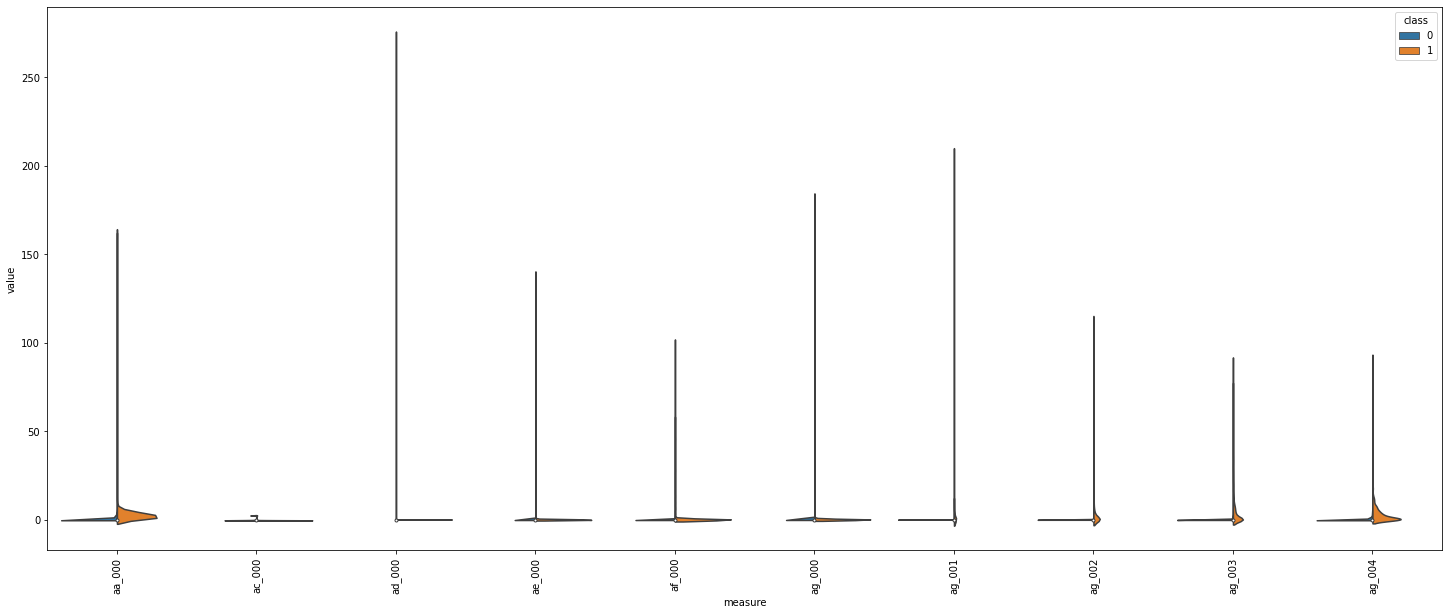

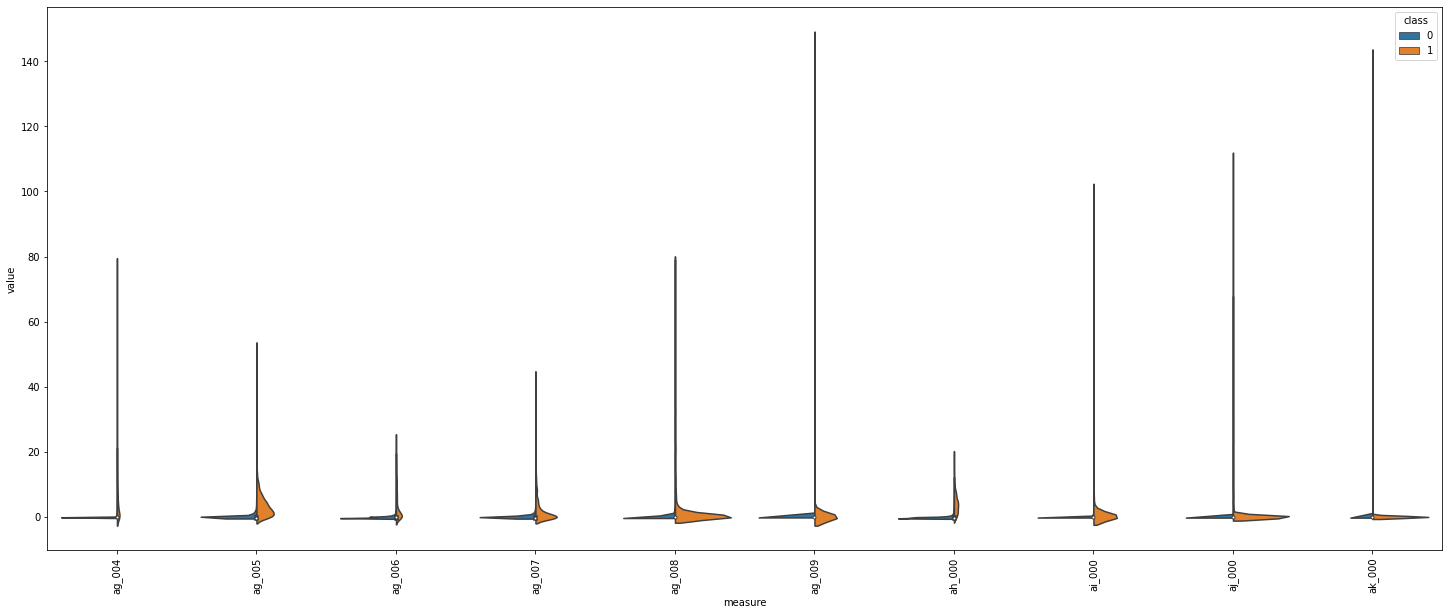

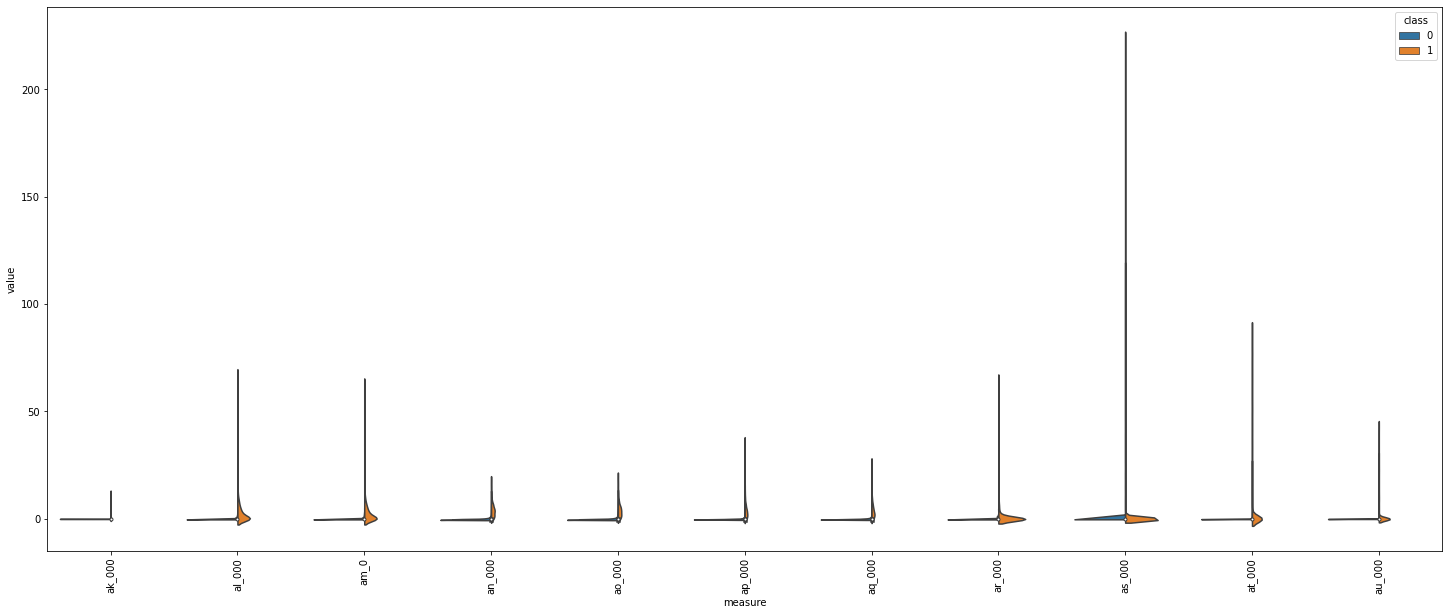

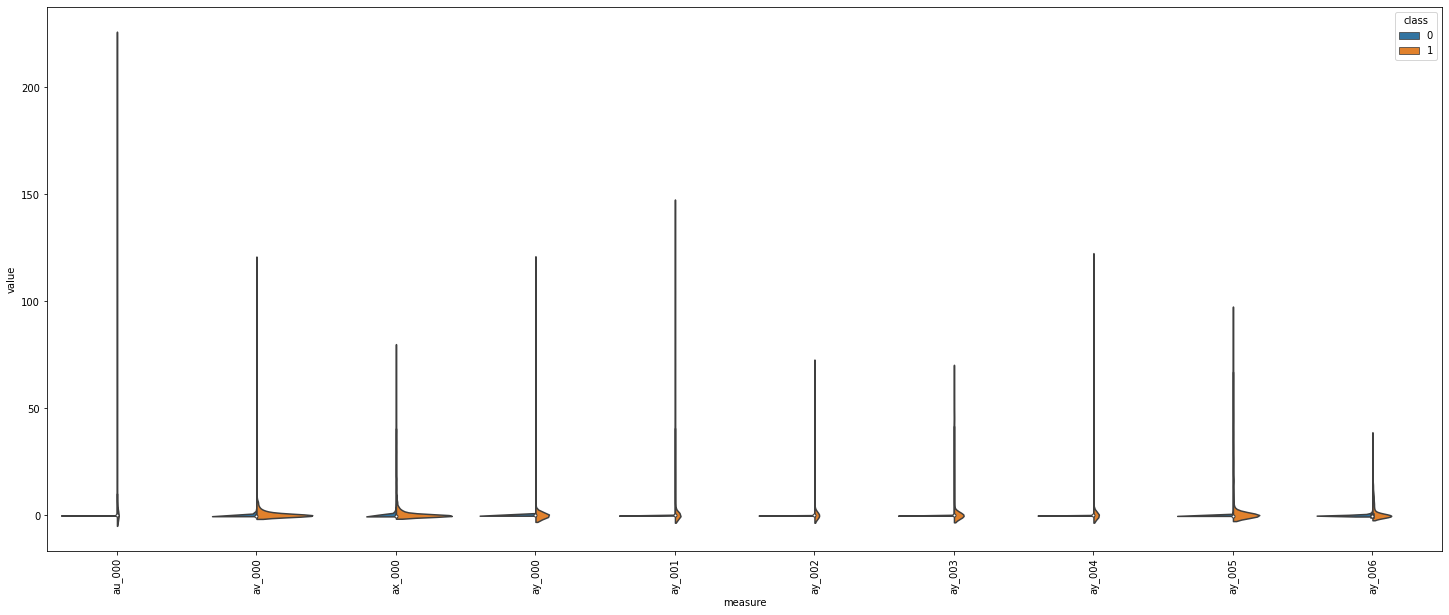

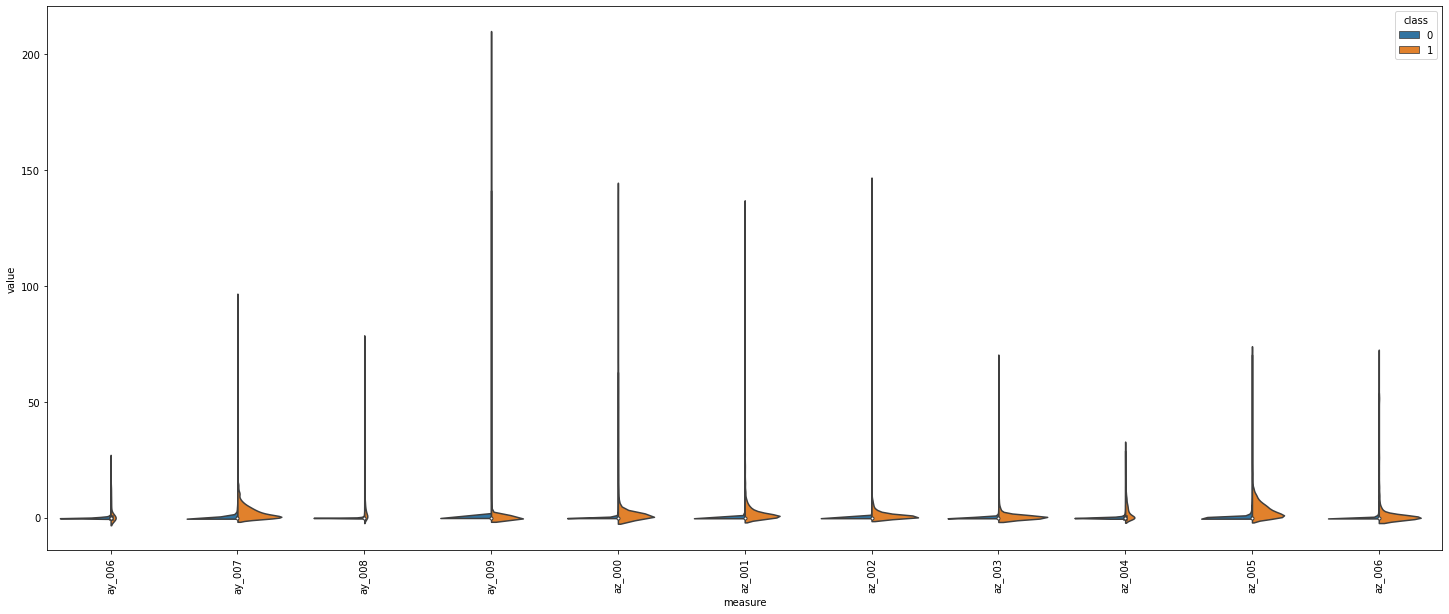

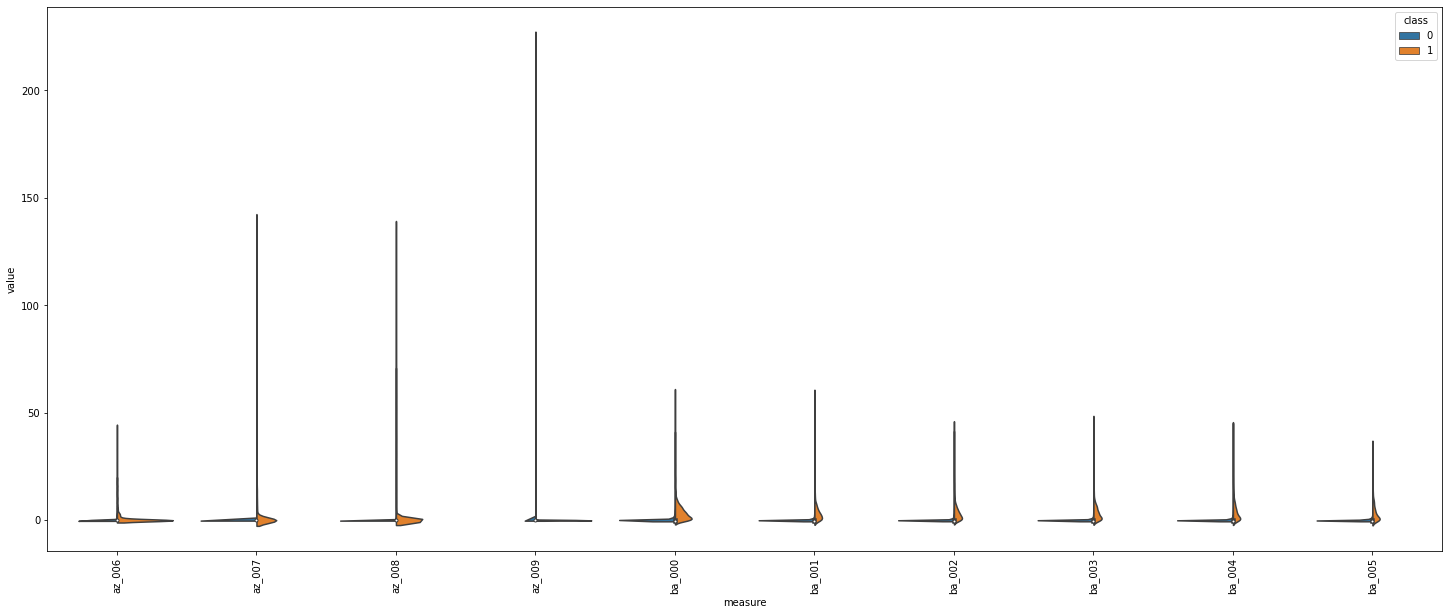

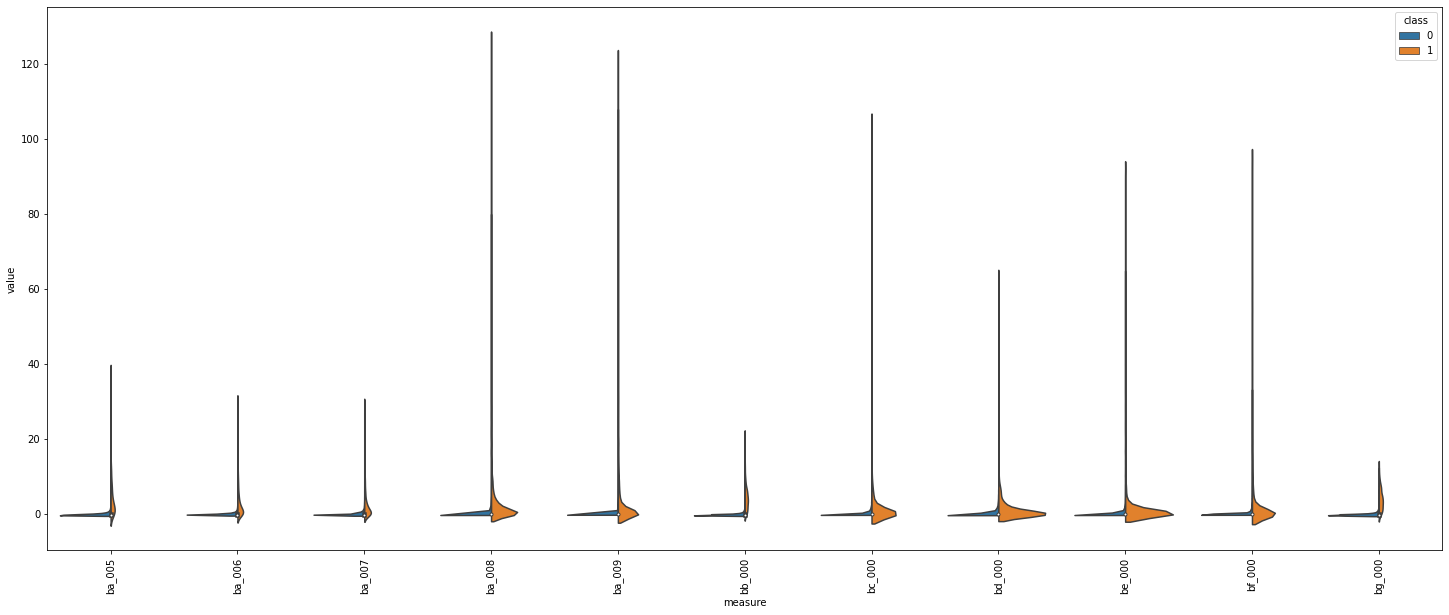

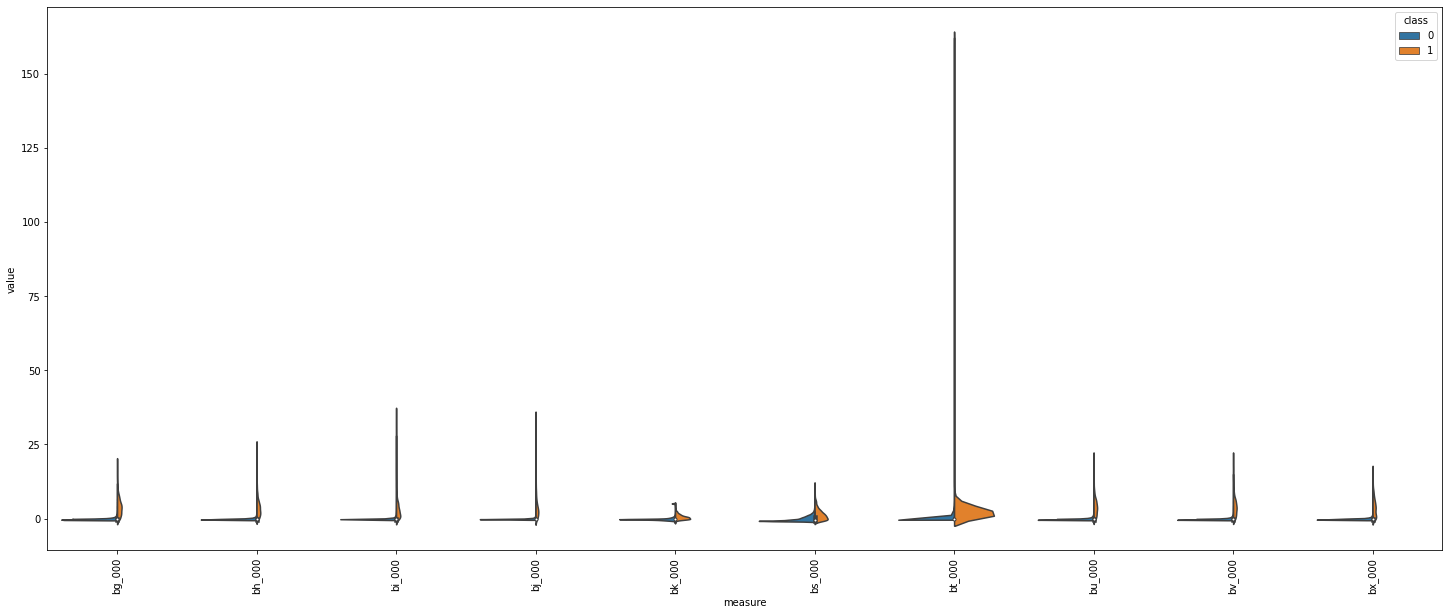

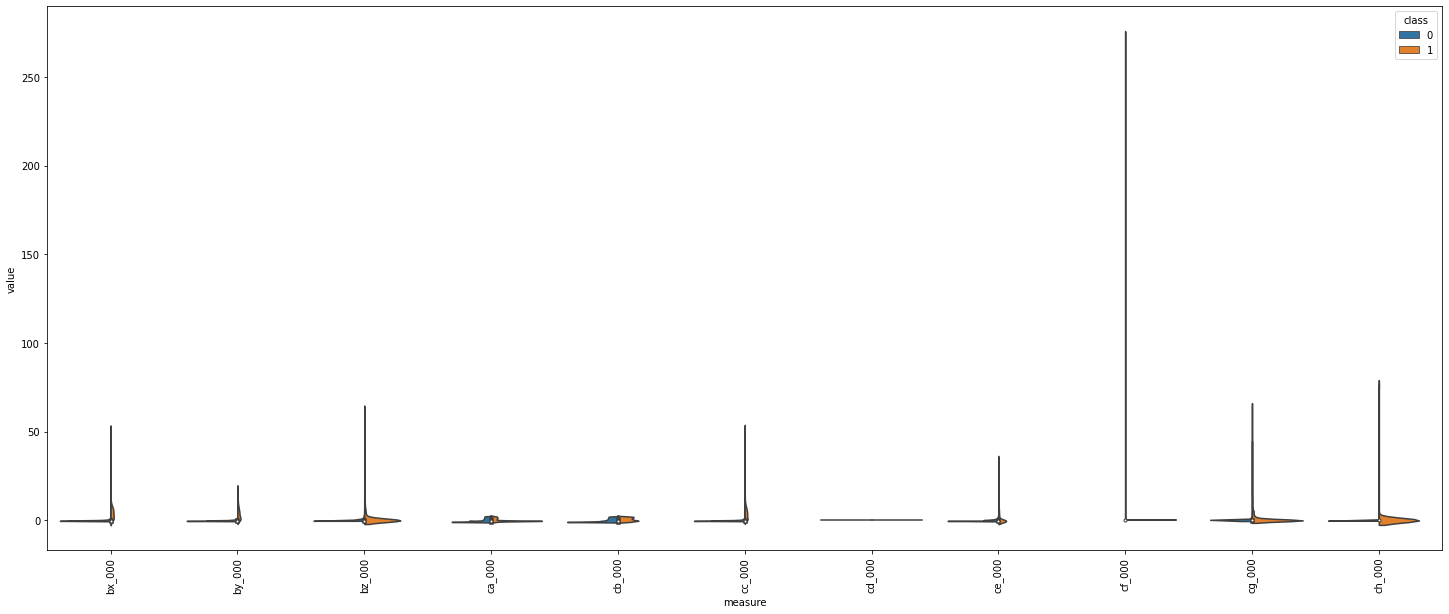

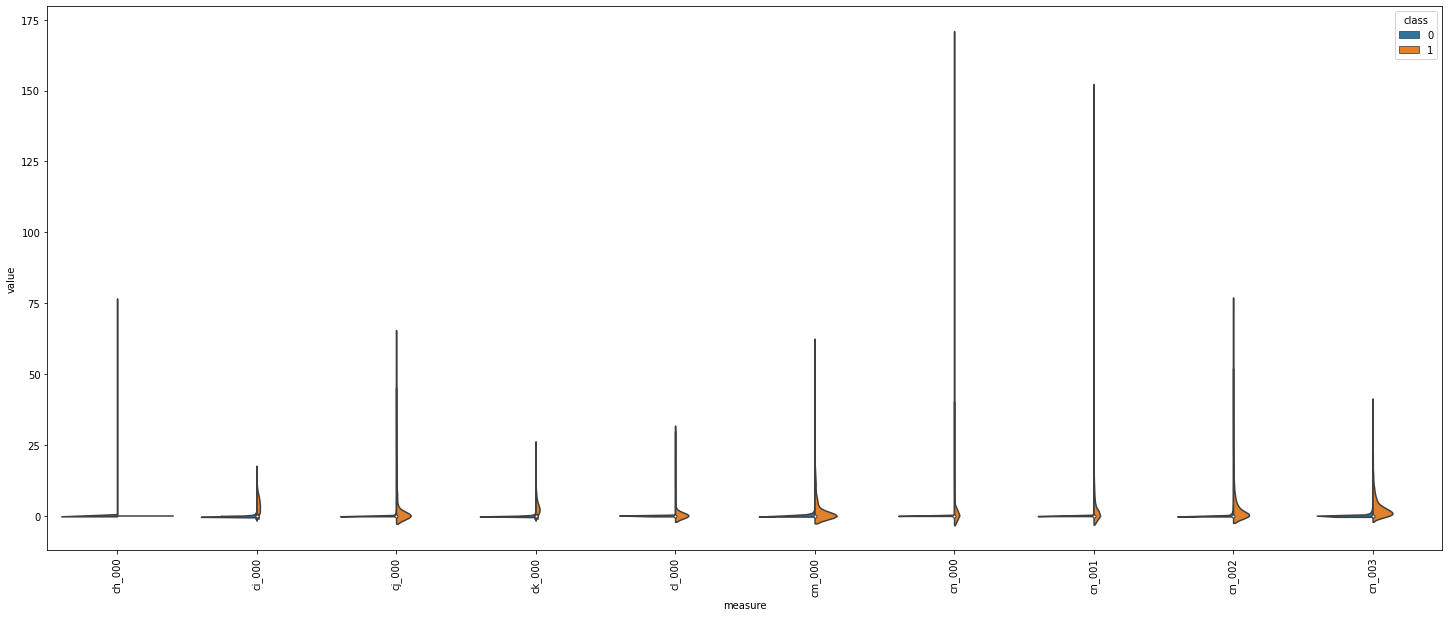

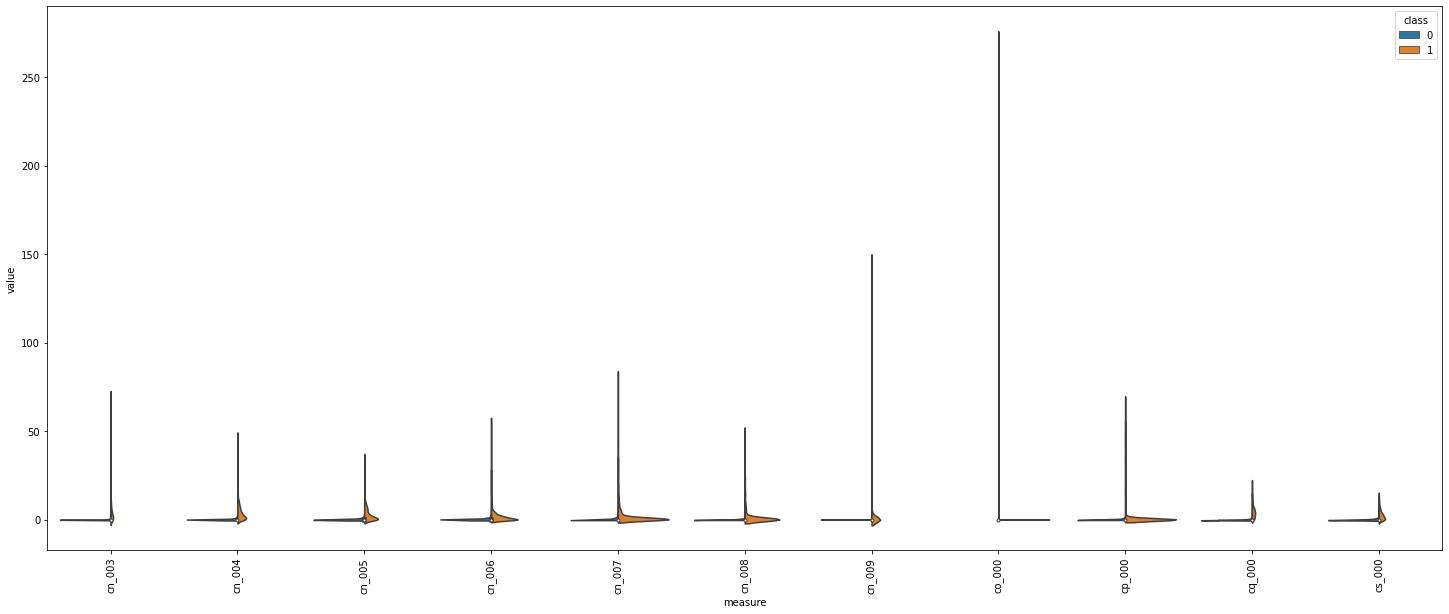

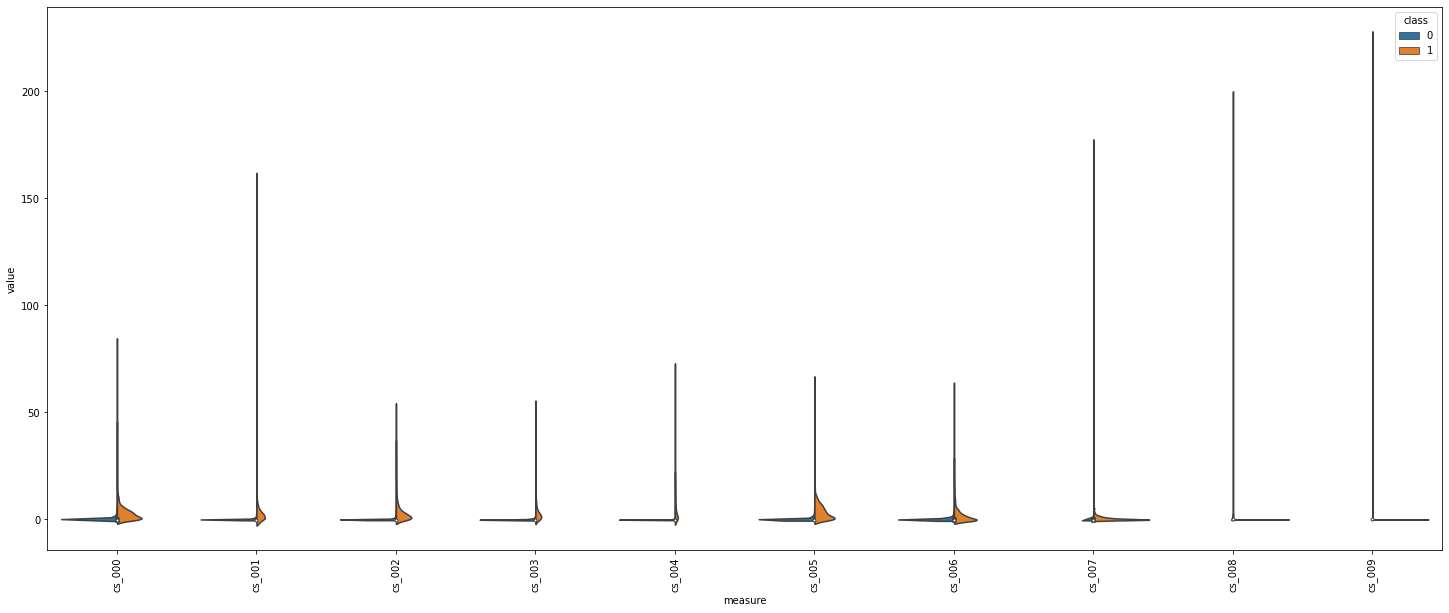

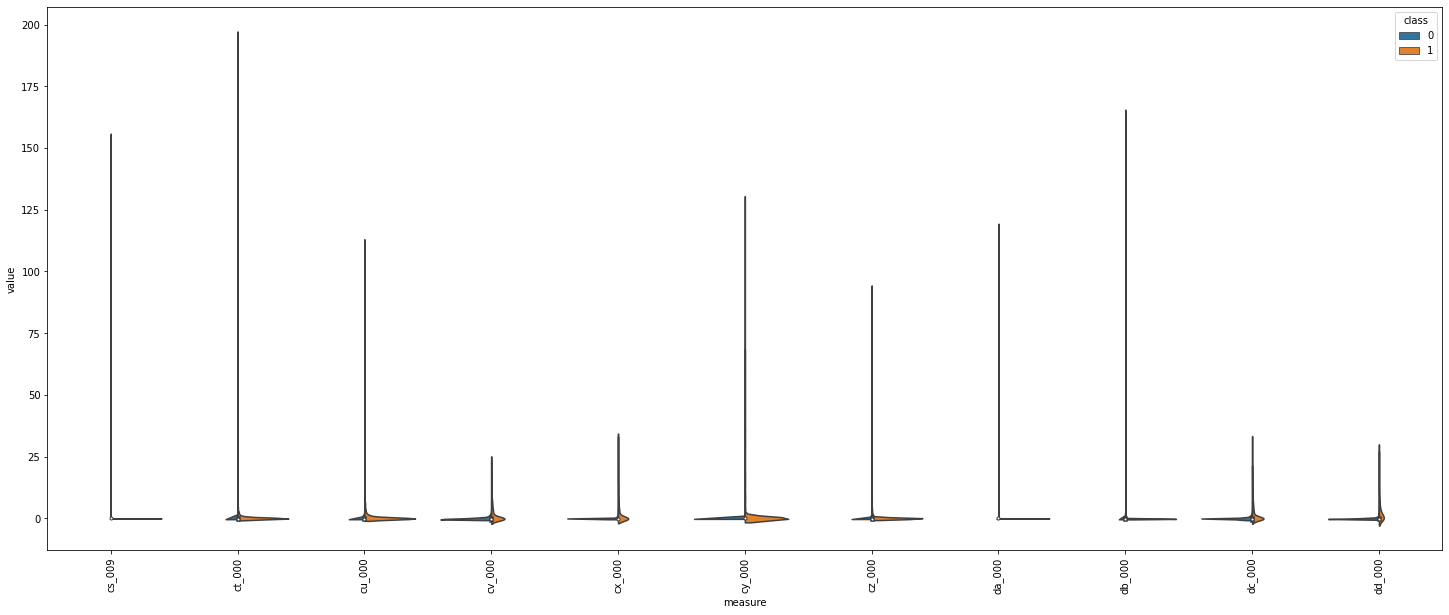

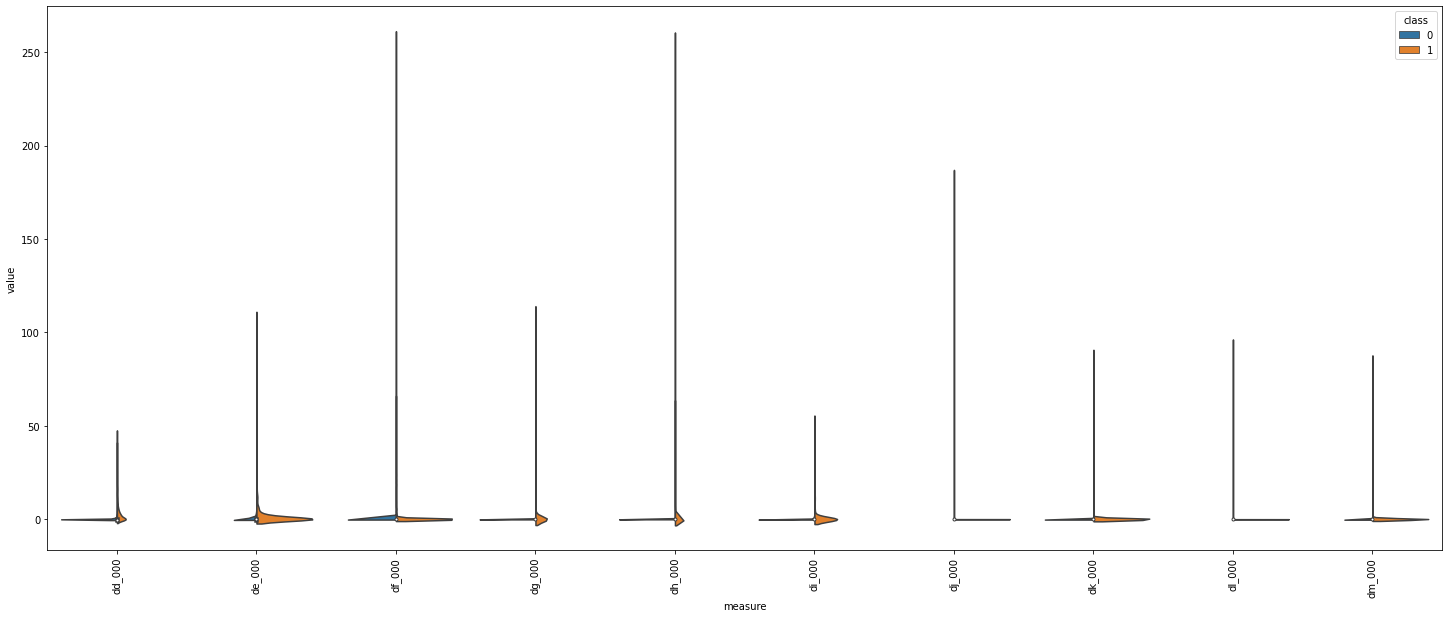

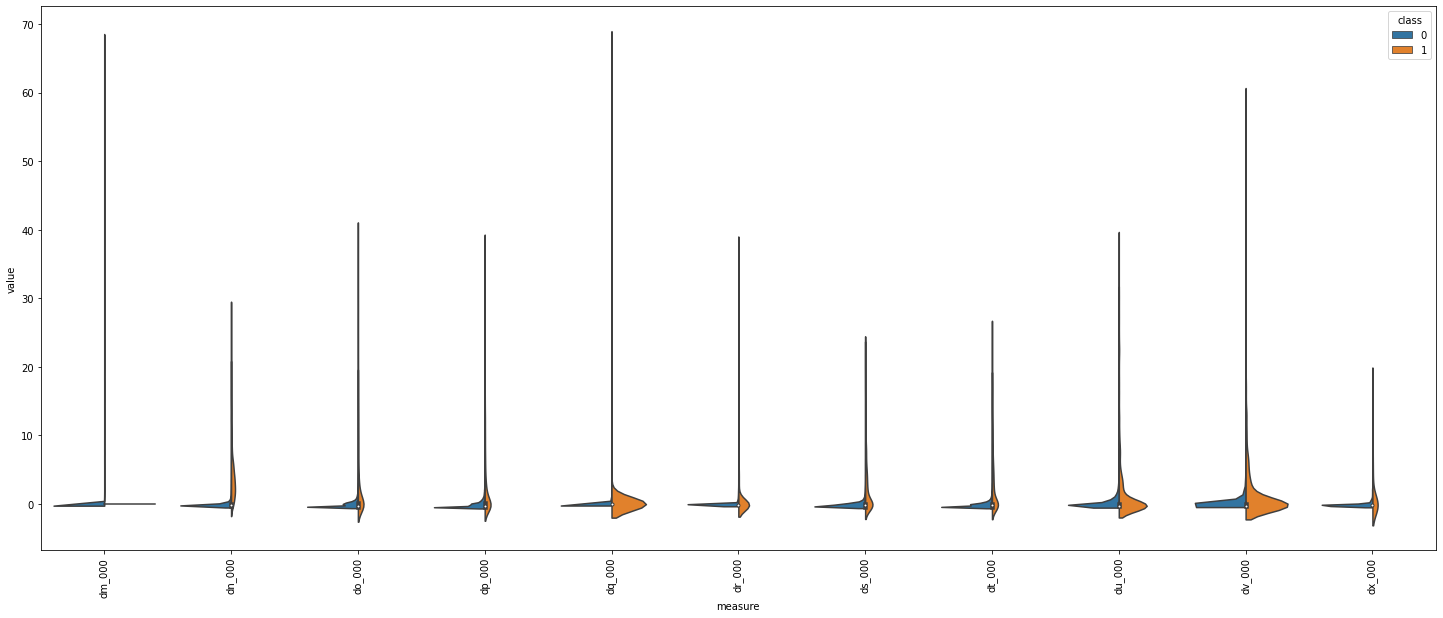

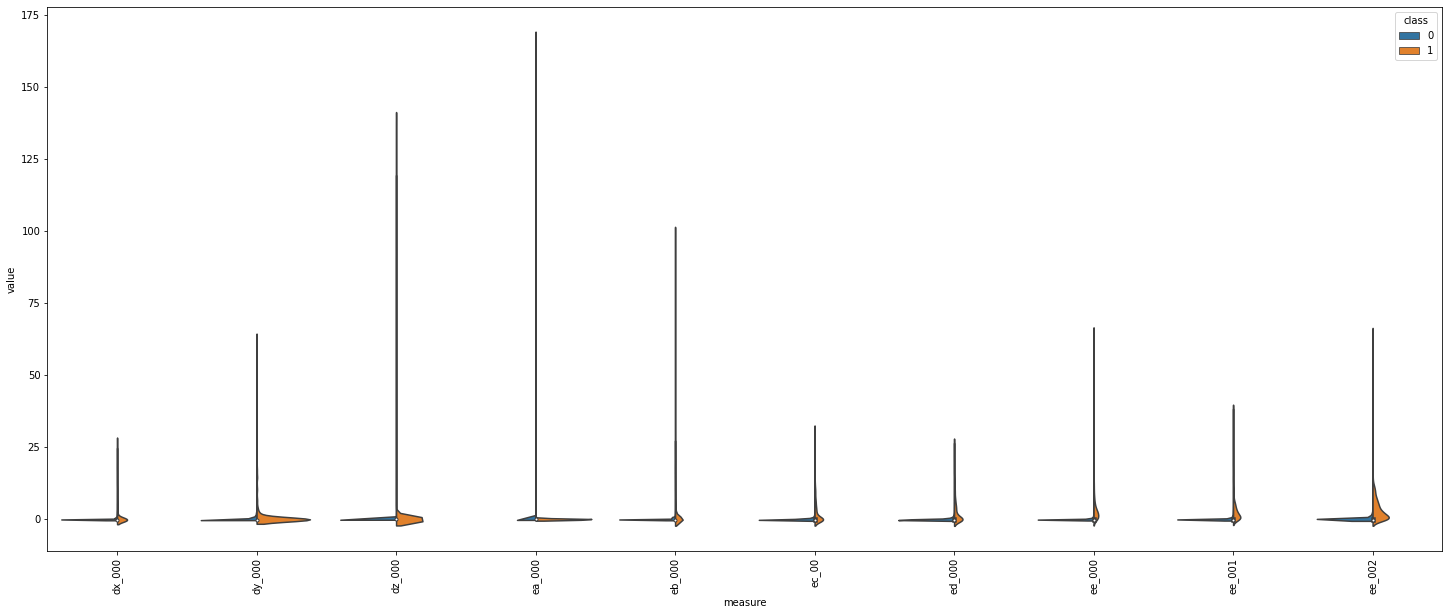

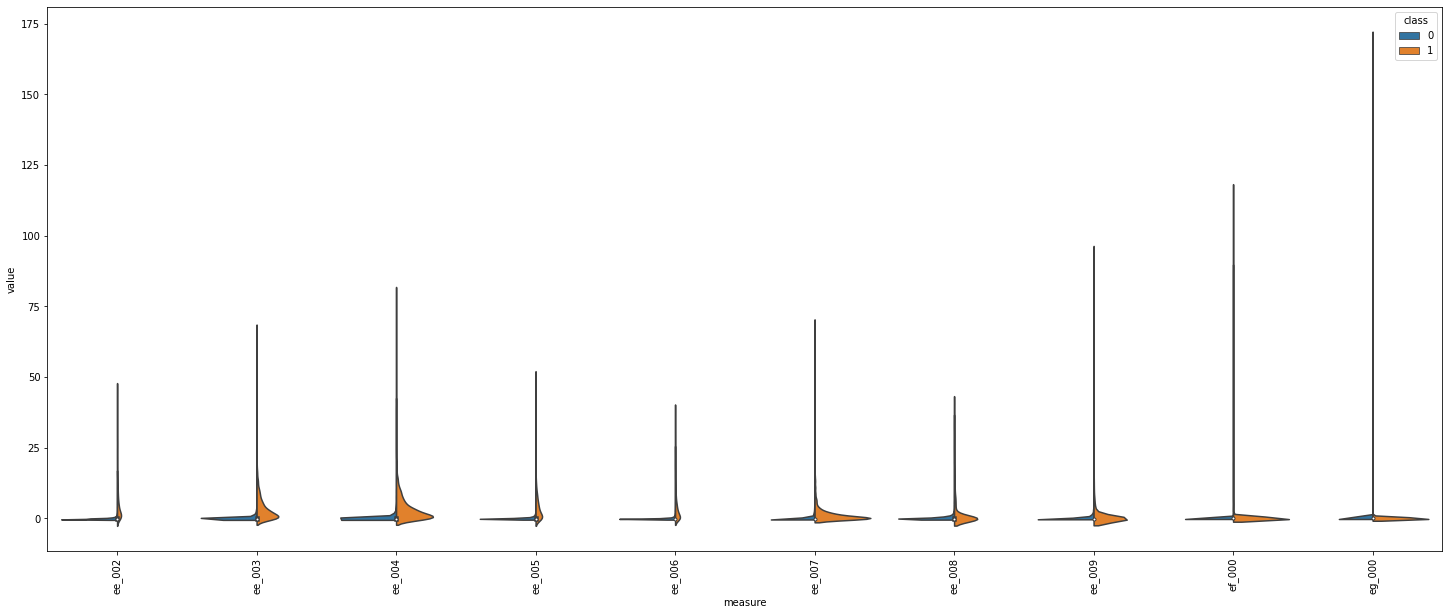

In [3]:
# Working on data to make violinplots and boxplots

data_original = data_raw.copy()

scaler = StandardScaler()
scaler.fit(data_raw.drop('class', axis = 1))
std_data = scaler.transform(data_raw.drop('class', axis = 1))

temp = pd.DataFrame(std_data, columns = data_raw.drop('class', axis = 1).columns)
target = data_raw['class']
std_data = pd.concat([temp, target], axis = 1)

temp = pd.melt(std_data, id_vars = 'class', var_name = 'measure', value_name = 'value')

# Violin Plot
for smaller_df in np.array_split(temp, 17):
  plt.figure(figsize = (25,10))
  sns.violinplot(x = 'measure',
                y = 'value',
                hue = 'class',
                data = smaller_df,
               split = True)
  plt.xticks(rotation = 90)
  plt.show()

# BoxPlot

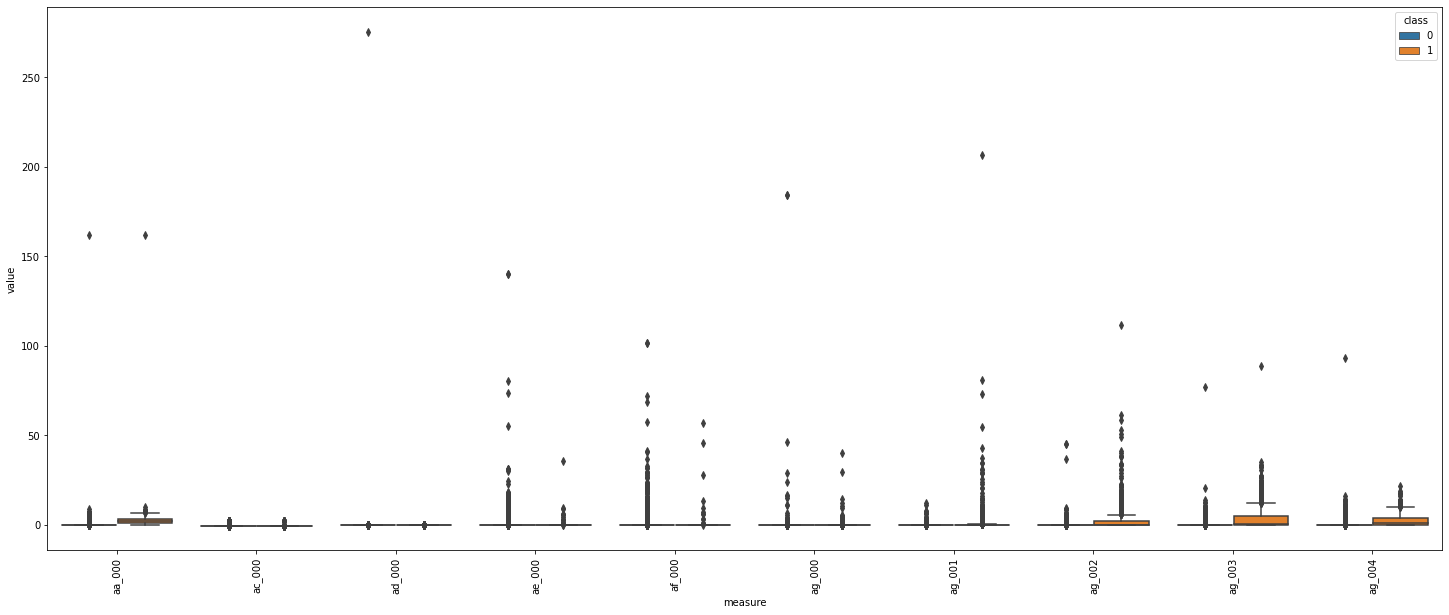

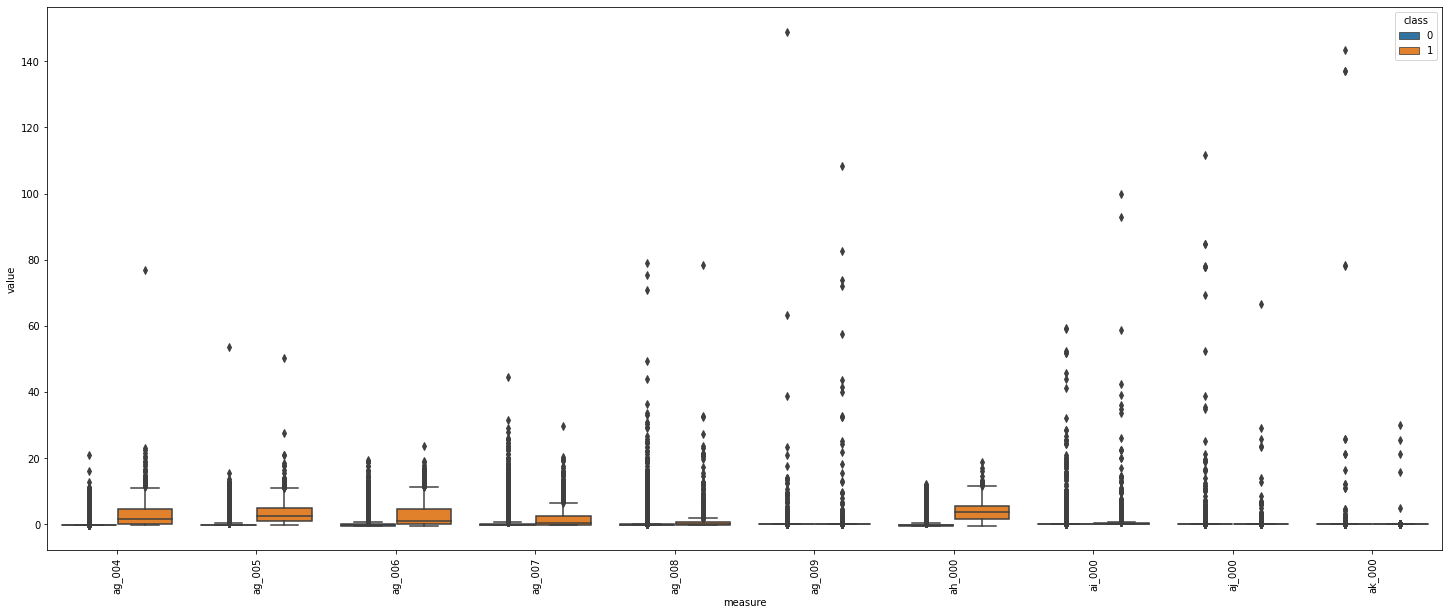

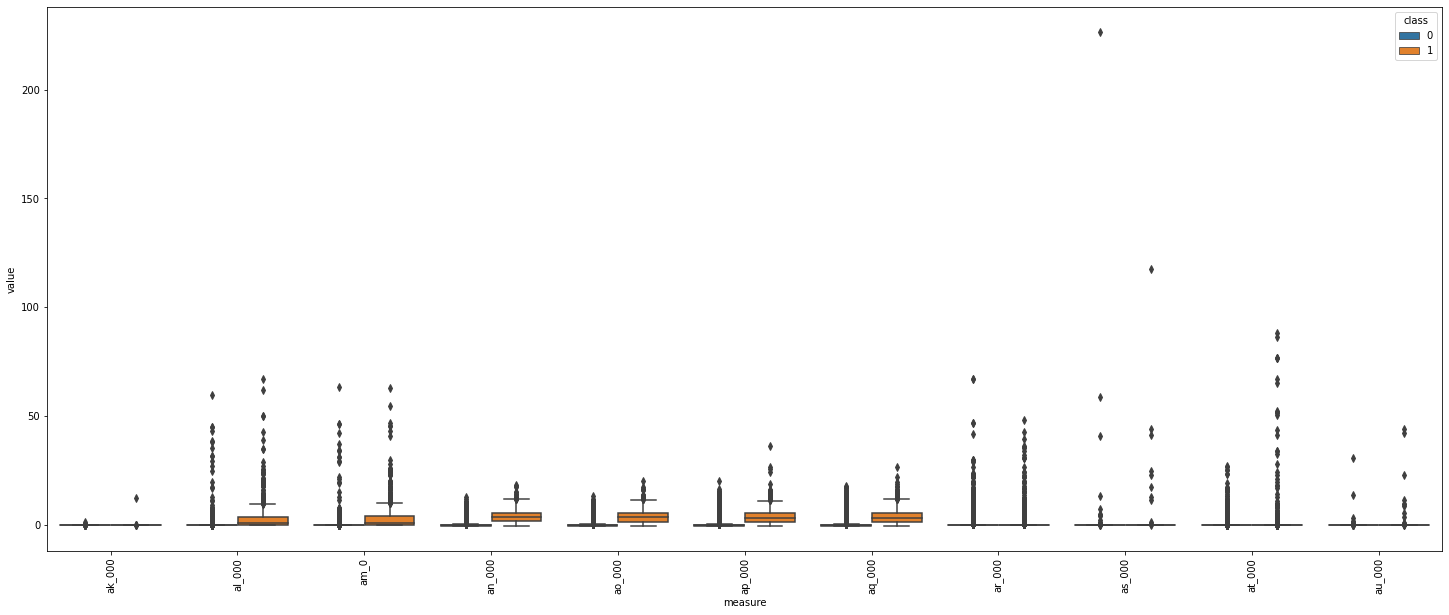

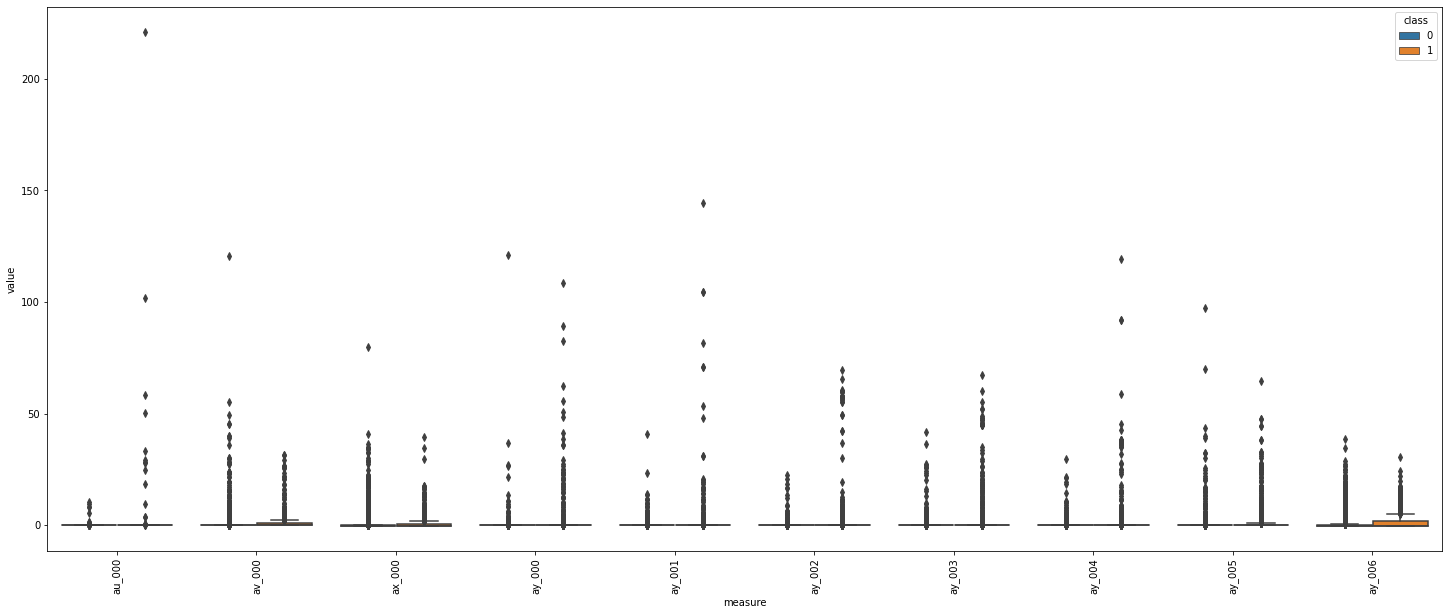

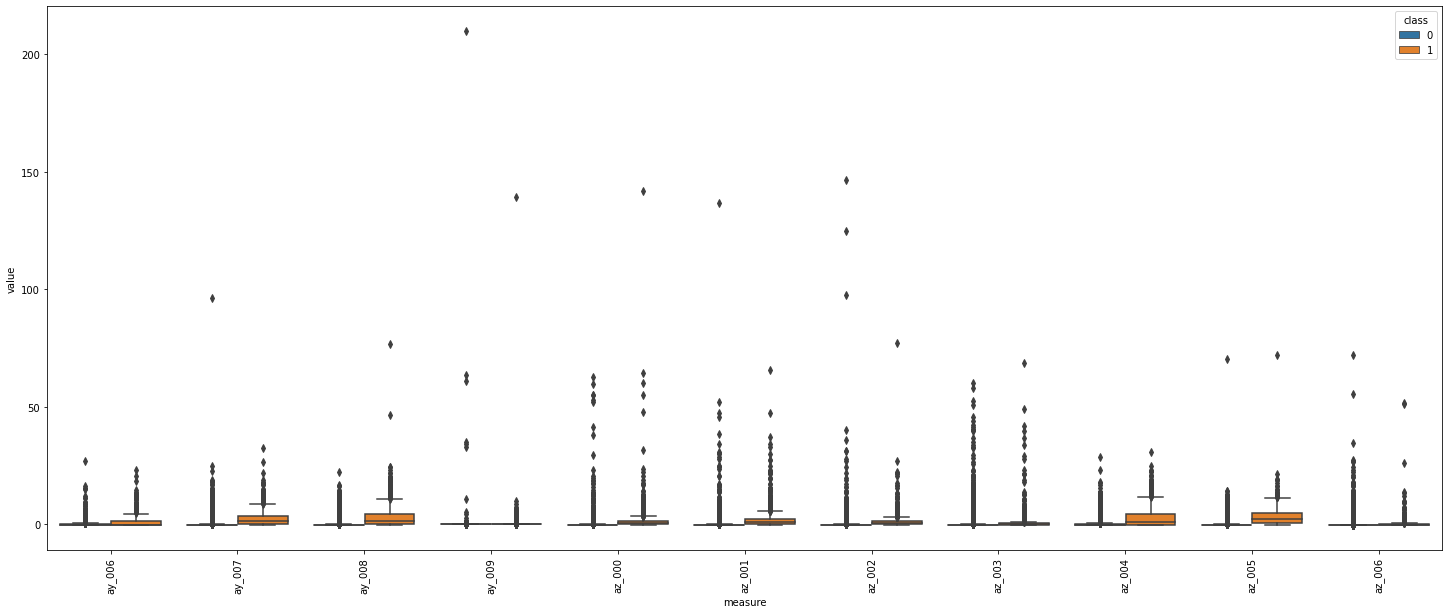

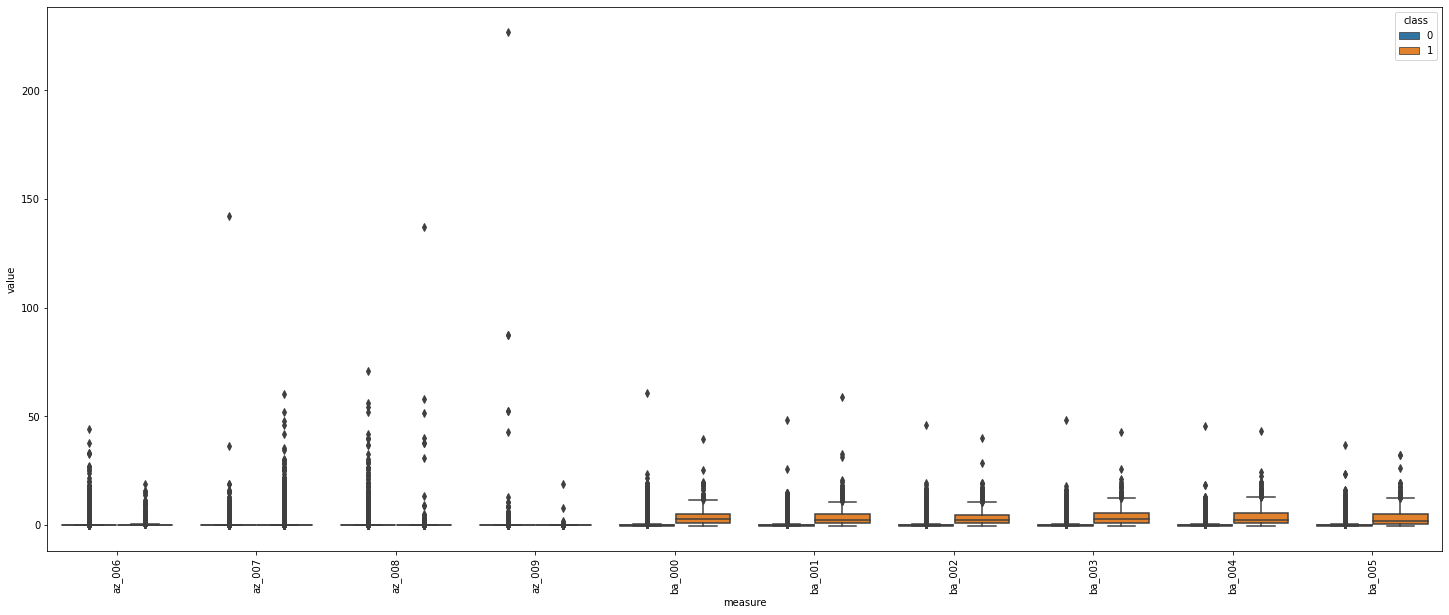

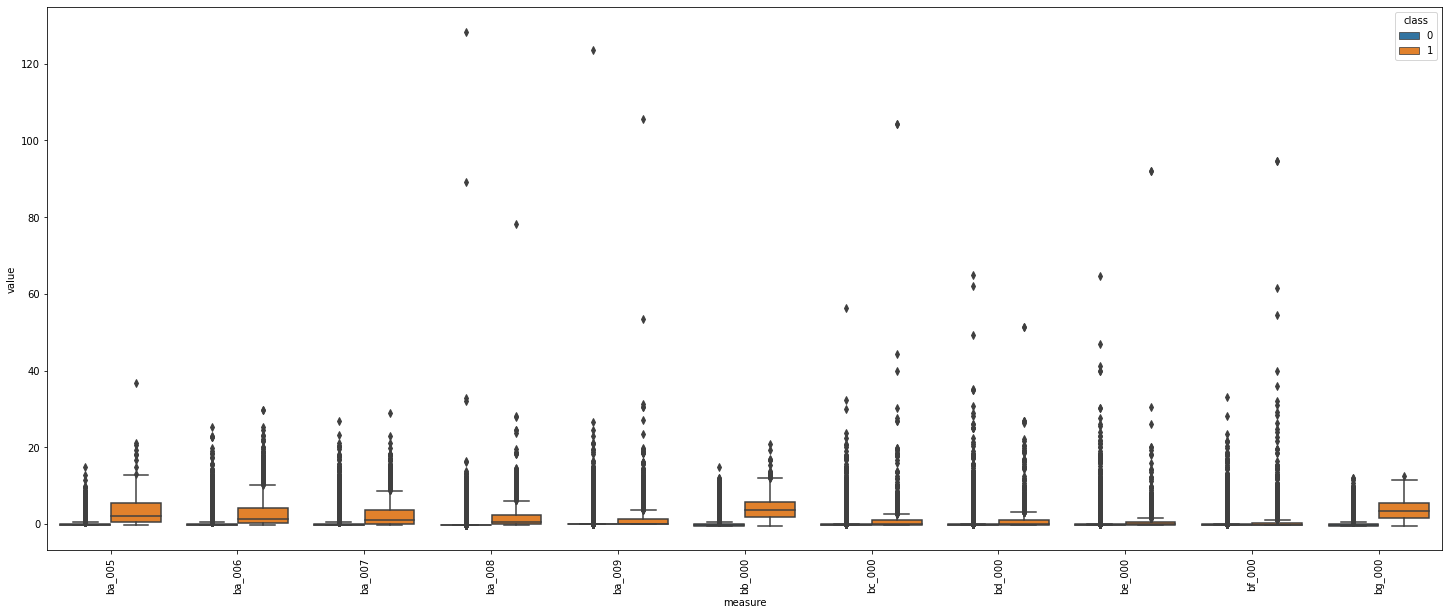

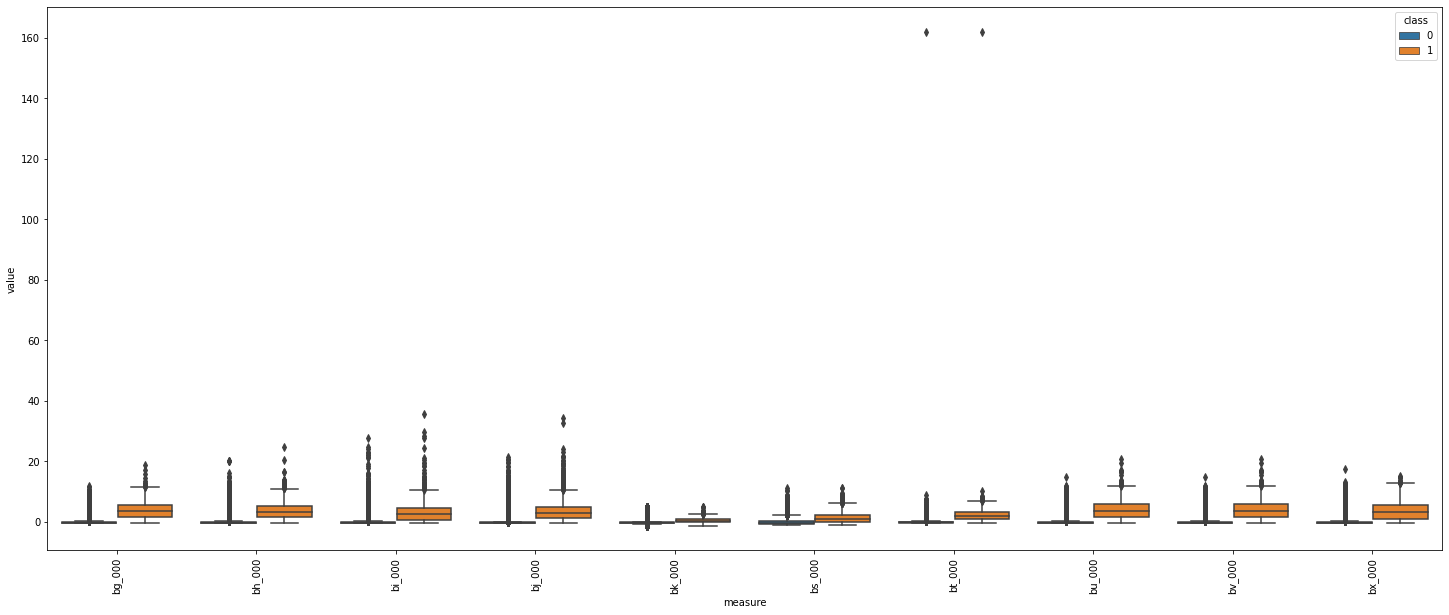

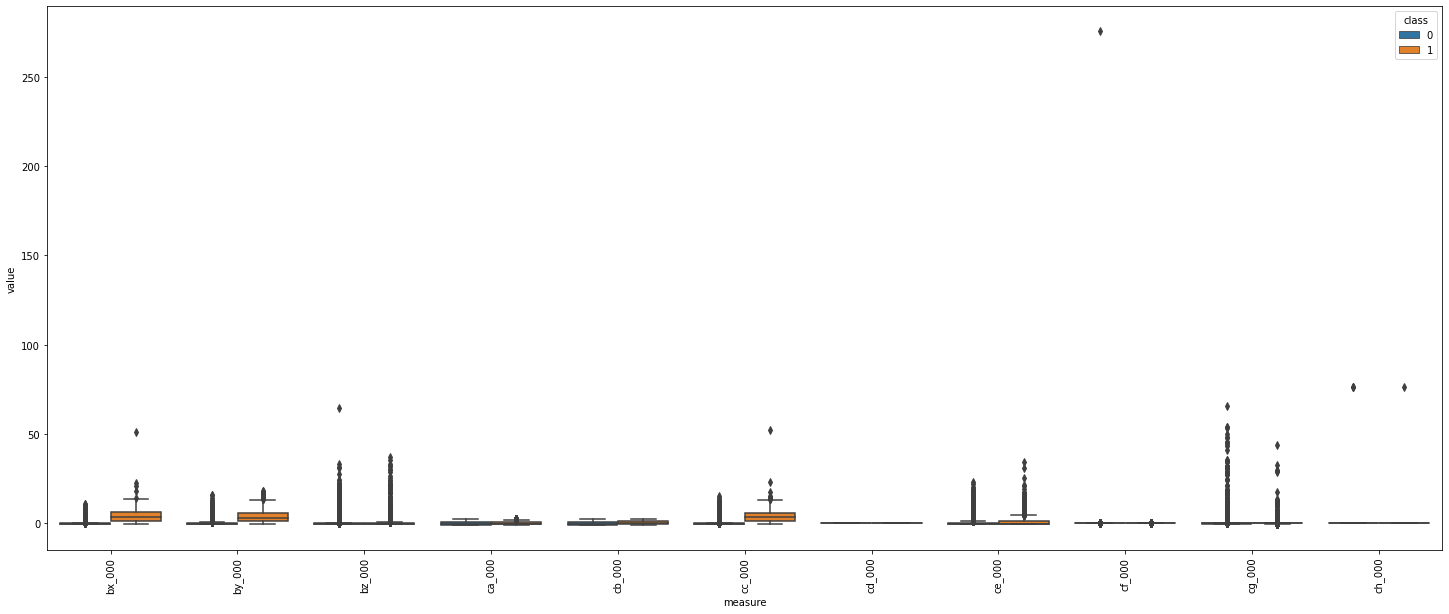

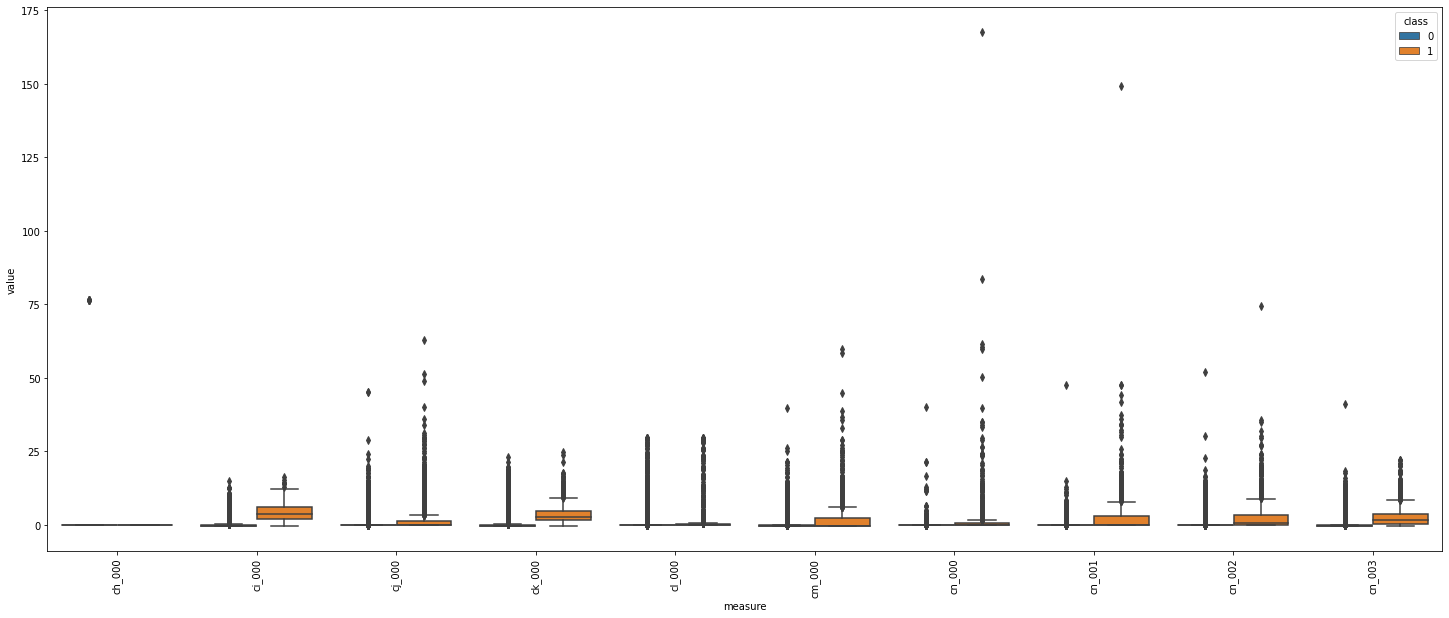

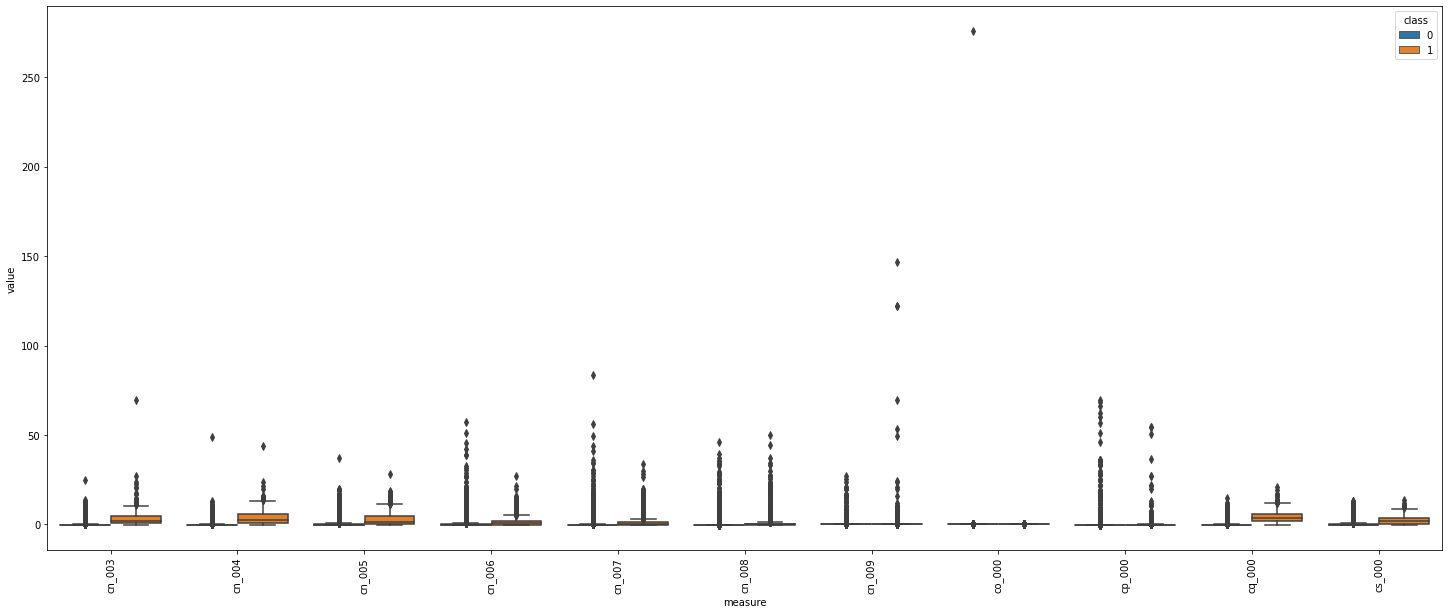

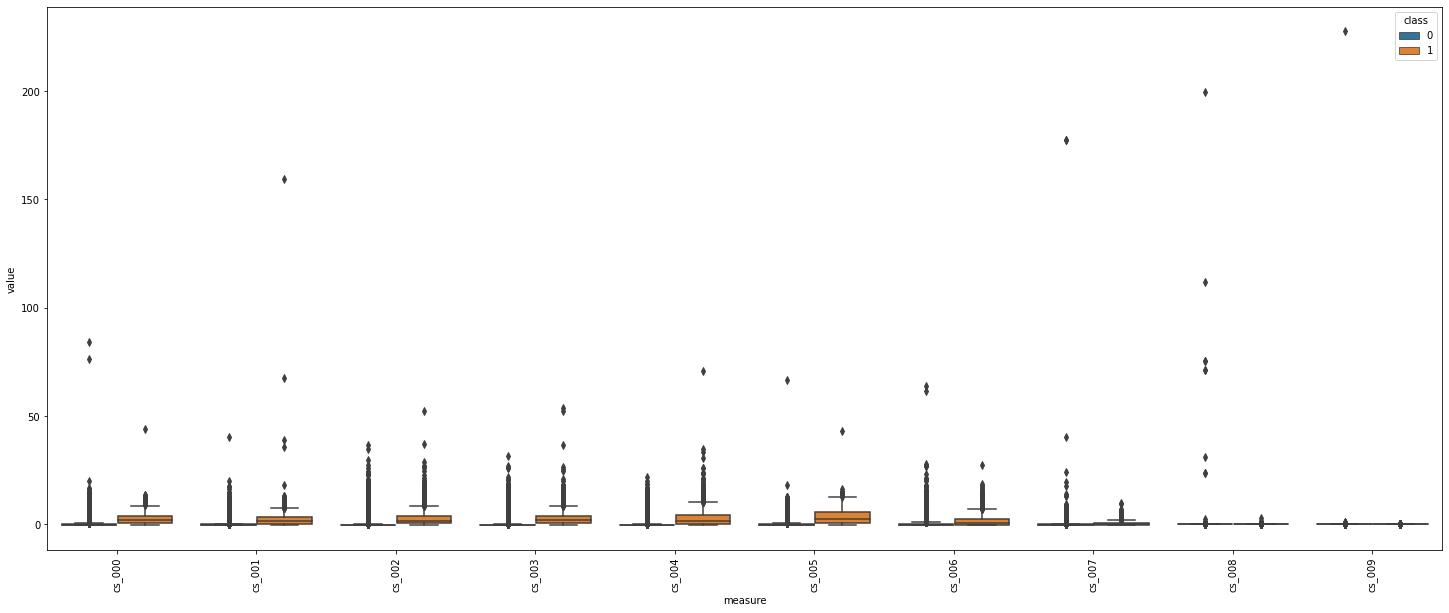

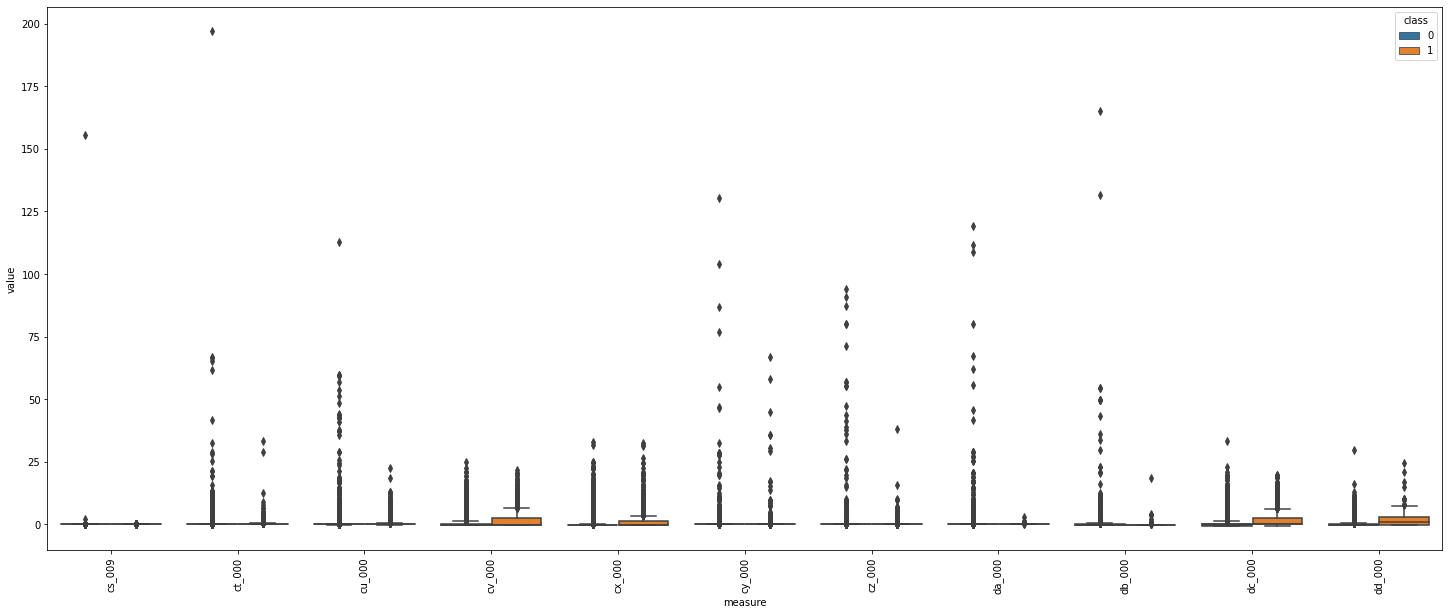

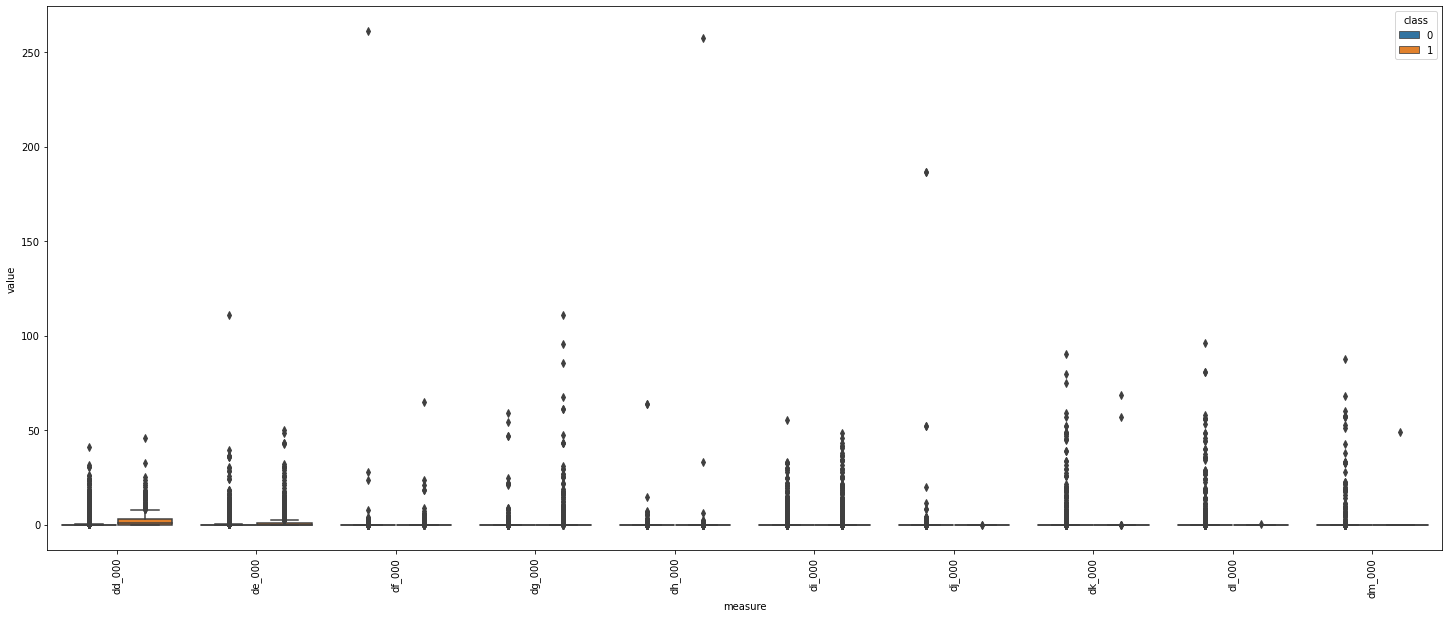

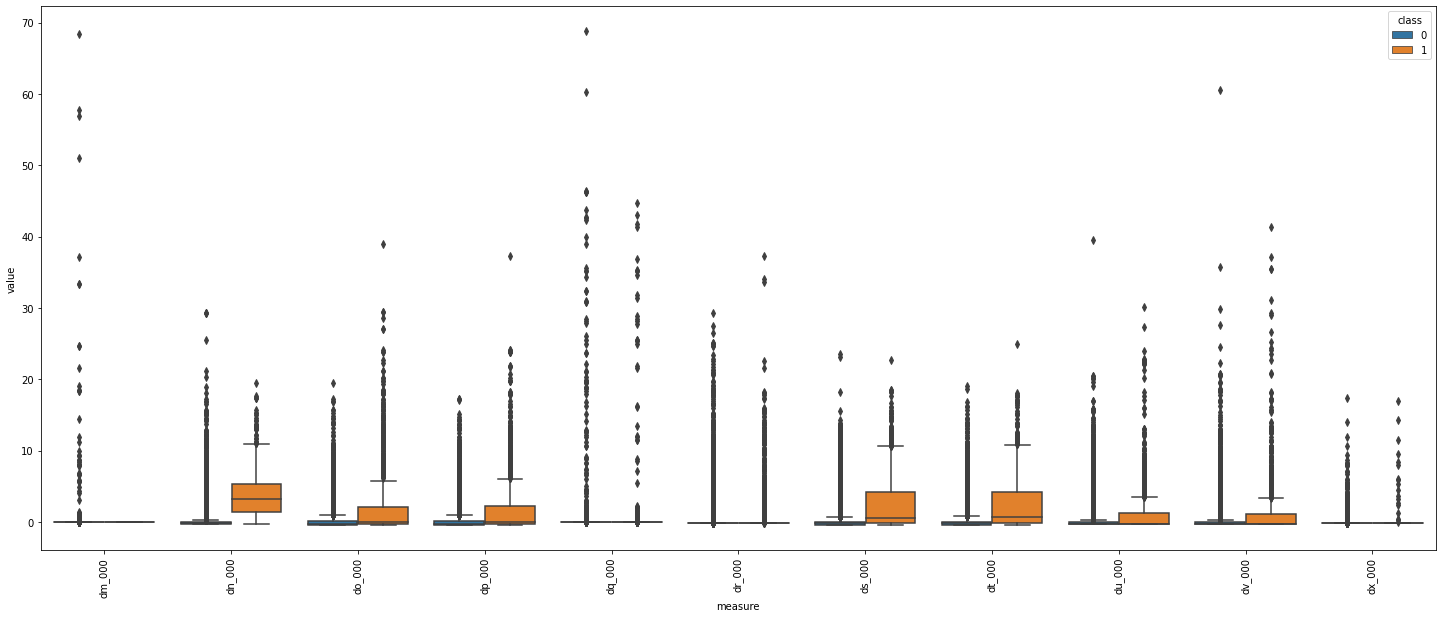

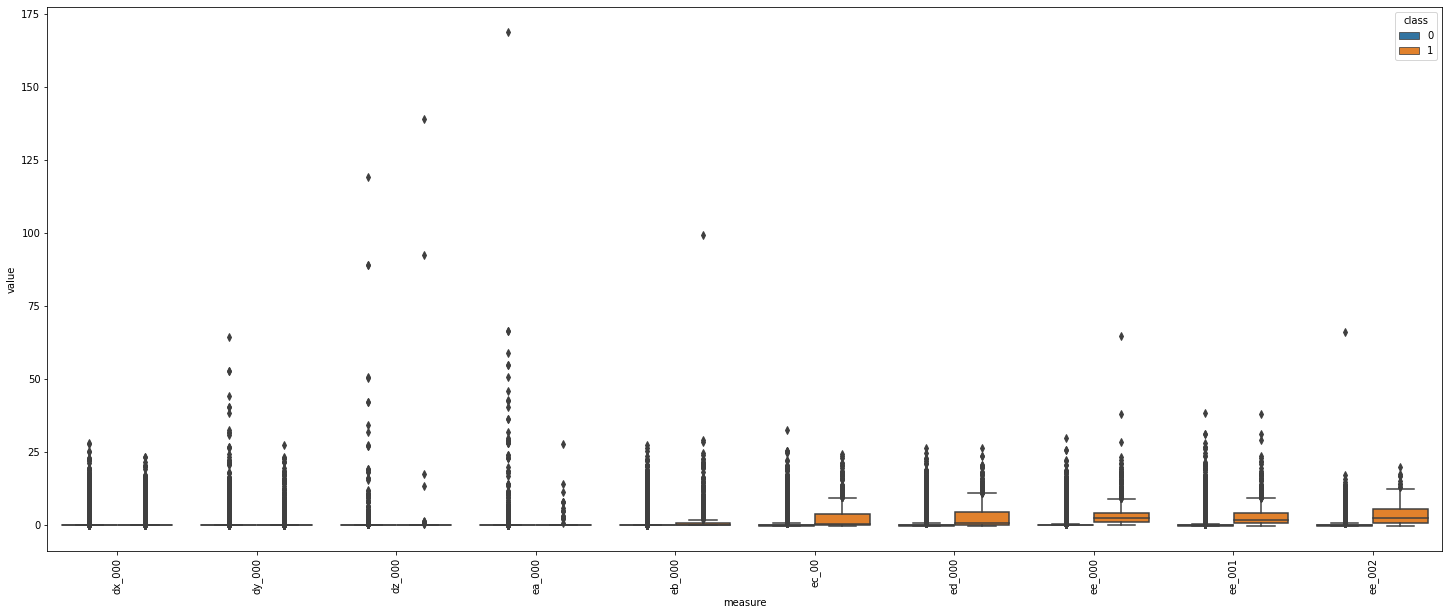

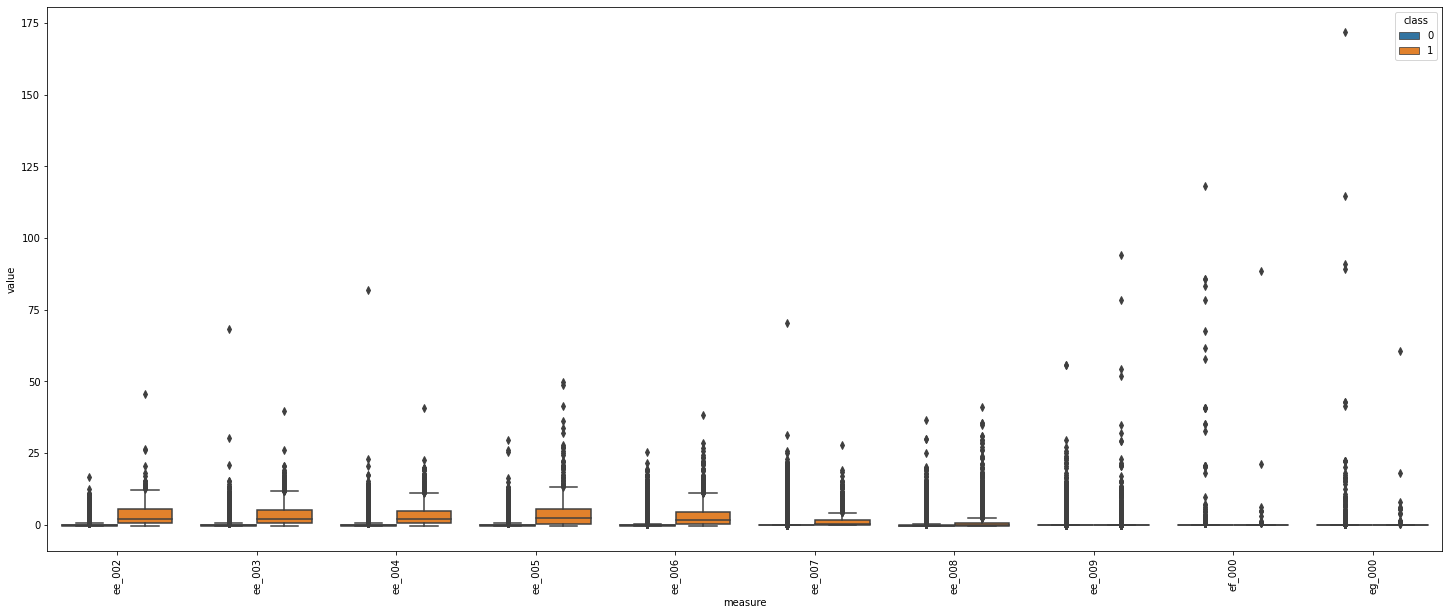

In [4]:
# Boxplot
for smaller_df in np.array_split(temp, 17):
  plt.figure(figsize = (25,10))
  sns.boxplot(x = 'measure',
                y = 'value',
                hue = 'class',
                data = smaller_df)
  plt.xticks(rotation = 90)
  plt.show()

# Data Cleanign and Feature Engineering

## try 1

Results for data with NaN values treated only.

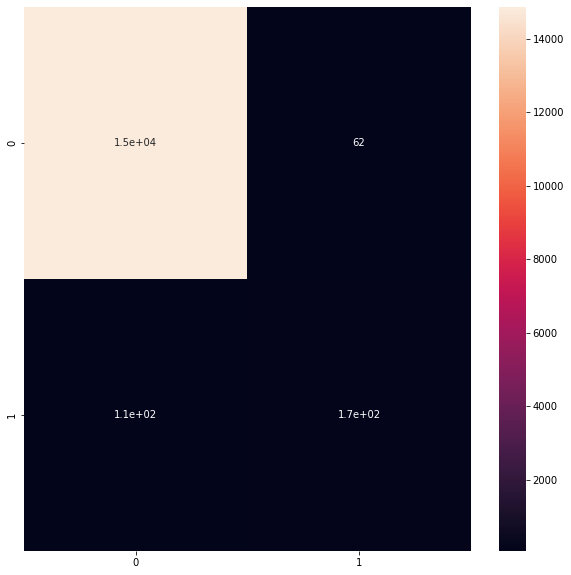

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14925
           1       0.73      0.60      0.66       275

    accuracy                           0.99     15200
   macro avg       0.86      0.80      0.83     15200
weighted avg       0.99      0.99      0.99     15200

new total cost : 3325000 | economy : 341000


In [5]:
features_1 = data_raw.drop('class', axis = 1)

report_1, matrix_1, tn_1, fp_1, fn_1, tp_1  = get_report(features_1, target)
plt.figure(figsize = (10,10))
sns.heatmap(matrix_1, annot = True)
plt.show()

print(report_1)

soma_1, economia_1 = total_costs(tn_1, fp_1, fn_1, tp_1)
print(f'new total cost : {soma_1} | economy : {economia_1}')

## try 2

Results for standardized data with NaN values treated.

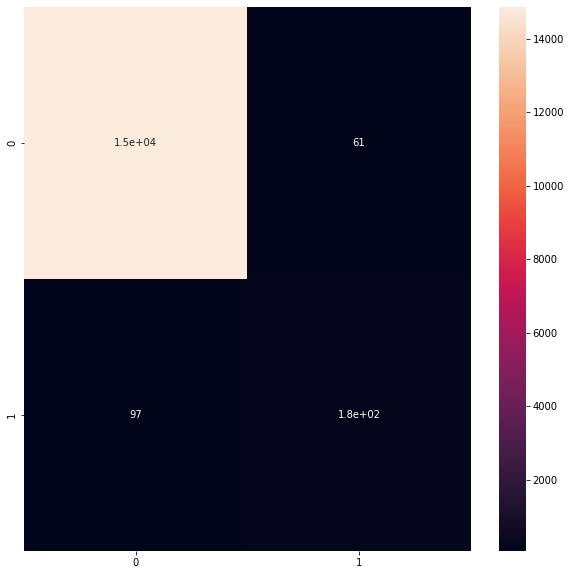

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14925
           1       0.74      0.65      0.69       275

    accuracy                           0.99     15200
   macro avg       0.87      0.82      0.84     15200
weighted avg       0.99      0.99      0.99     15200

new total cost : 3306500 | economy : 359500


In [6]:
features_2 = std_data.drop('class', axis = 1)

report_2, matriz_2, tn_2, fp_2, fn_2, tp_2  = get_report(features_2, target)
plt.figure(figsize = (10,10))
sns.heatmap(matriz_2, annot = True)
plt.show()

print(report_2)

soma_2, economia_2 = total_costs(tn_2, fp_2, fn_2, tp_2)
print(f'new total cost : {soma_2} | economy : {economia_2}')

## try 3

Results for data with outliers treated (IQR method) and NaN values treated.

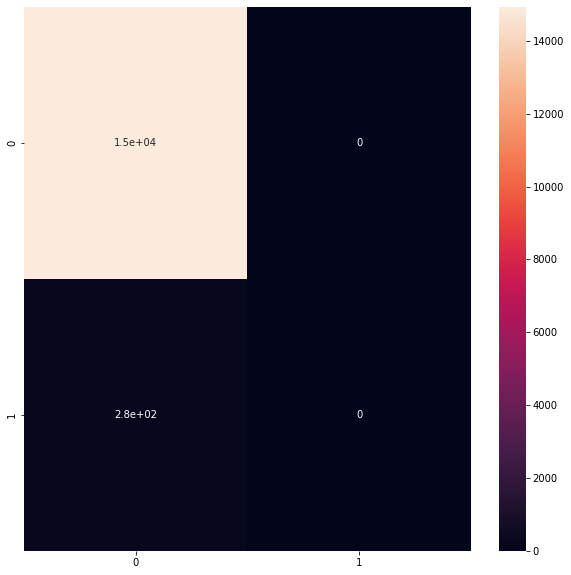

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14925
           1       0.00      0.00      0.00       275

    accuracy                           0.98     15200
   macro avg       0.49      0.50      0.50     15200
weighted avg       0.96      0.98      0.97     15200

new total cost : 3720000 | economy -54000


In [7]:
from scipy.stats import iqr

data_wth_outliers = []

for column in data_raw.drop('class', axis = 1):
  temp = data_raw[column].sort_values(ascending = True)
  temp = np.array(temp)
  IQR = iqr(temp)
  Q1 = np.quantile(temp, 0.25)
  Q3 = np.quantile(temp, 0.75)
  c = 0.3
  inf_limit =  Q3 + (IQR*c)
  sup_limit = Q1 - (IQR*c)

  array_wth_outliers = []
  for i in temp:
    if (i > sup_limit) or (i < inf_limit):
      array_wth_outliers.append(-1)
    else:
      array_wth_outliers.append(i)

  data_wth_outliers.append(array_wth_outliers)

data_wth_outliers = np.transpose(data_wth_outliers)
outliers_removed = pd.DataFrame(data_wth_outliers, columns = data_raw.drop('class', axis = 1).columns)

report_3, matriz_3, tn_3, fp_3, fn_3, tp_3  = get_report(outliers_removed, target)
plt.figure(figsize = (10,10))
sns.heatmap(matriz_3, annot = True)
plt.show()

print(report_3)

soma_3, economia_3 = total_costs(tn_3, fp_3, fn_3, tp_3)
print(f'new total cost : {soma_3} | economy {economia_3}')

## try 4

standardized data with constants dropped 

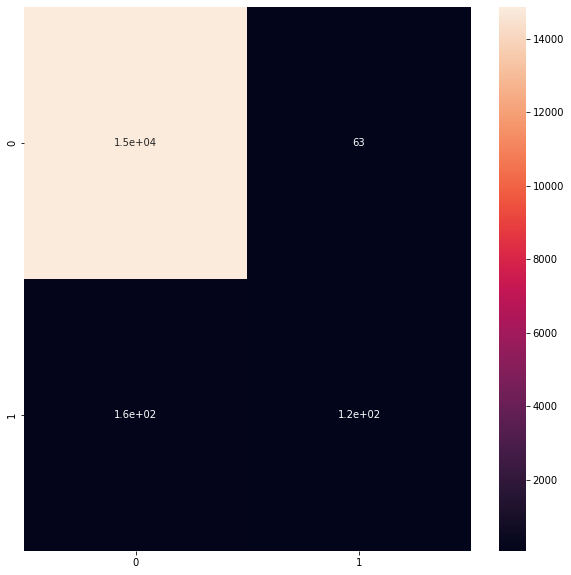

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14925
           1       0.65      0.42      0.51       275

    accuracy                           0.99     15200
   macro avg       0.82      0.71      0.75     15200
weighted avg       0.98      0.99      0.98     15200

new total cost : 3454500 | economy : 211500


In [8]:
features_4 = features_2[['ad_000', 'ah_000', 'ak_000', 'an_000', 'ao_000', 'ap_000',
                         'aq_000', 'bb_000', 'bg_000',
                         'bh_000', 'bj_000', 'bu_000', 'bv_000', 'bx_000', 'cc_000', 'cf_000',
                         'ck_000', 'ci_000', 'cq_000', 'cs_000', 'cs_008', 'cs_009', 'dn_000', 'ee_000']]

report_4, matriz_4, tn_4, fp_4, fn_4, tp_4  = get_report(features_4, target)
plt.figure(figsize = (10,10))
sns.heatmap(matriz_4, annot = True)
plt.show()

print(report_4)

soma_4, economia_4 = total_costs(tn_4, fp_4, fn_4, tp_4)
print(f'new total cost : {soma_4} | economy : {economia_4}')

## try 5

standardized data with less descriptive features removed.

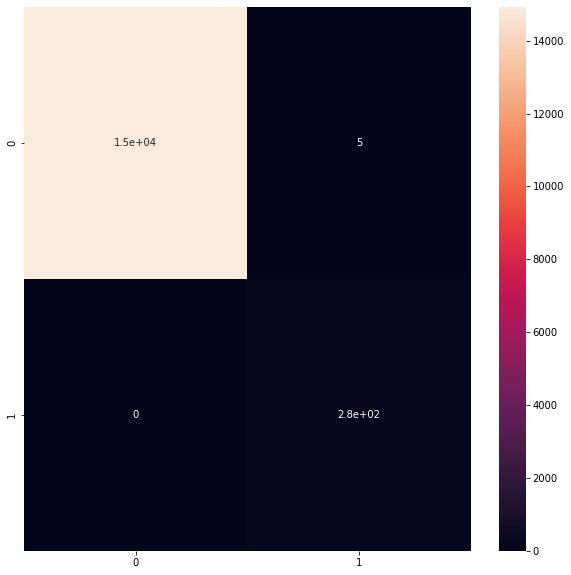

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14925
           1       0.98      1.00      0.99       275

    accuracy                           1.00     15200
   macro avg       0.99      1.00      1.00     15200
weighted avg       1.00      1.00      1.00     15200

new total cost : 3055500 | economy : 610500


In [9]:
features_5 = std_data.drop(['ac_000', 'cs_000', 'cd_000', 'ef_000', 'eg_000', 'du_000',
                              'dp_000', 'ea_000', 'df_000', 'dc_000', 'ct_000', 'cu_000',
                              'db_000', 'ce_000', 'ak_000', 'as_000', 'cg_000', 'ca_000', 'cb_000'], axis = 1)

report_5, matriz_5, tn_5, fp_5, fn_5, tp_5  = get_report(features_5, target)
plt.figure(figsize = (10,10))
sns.heatmap(matriz_5, annot = True)
plt.show()

print(report_5)

soma_5, economia_5 = total_costs(tn_5, fp_5, fn_5, tp_5)
print(f'new total cost : {soma_5} | economy : {economia_5}')

## try 6

SMOTE(Synthetic Minority Oversampling Technique) in standardized data

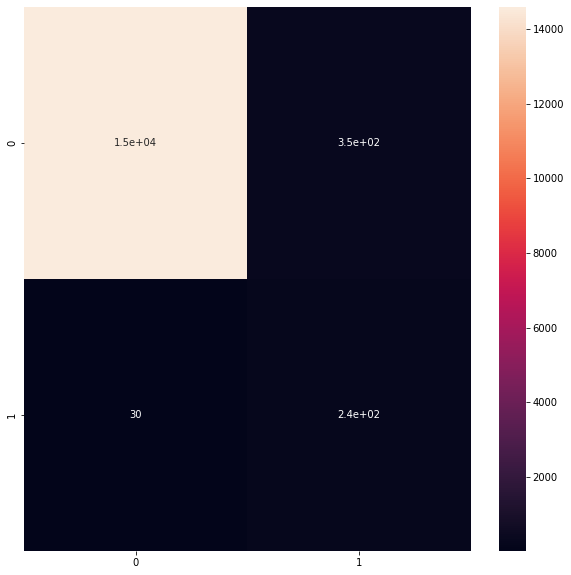

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14925
           1       0.41      0.89      0.57       275

    accuracy                           0.98     15200
   macro avg       0.71      0.93      0.78     15200
weighted avg       0.99      0.98      0.98     15200



new total cost : 3197000 | economy : 469000


In [10]:
oversample = SMOTE(sampling_strategy = 0.7)
undersample = RandomUnderSampler()

steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps = steps)

x_train, x_test, y_train, y_test = train_test_split(std_data.drop('class', axis = 1), target, stratify = target, random_state = 16, train_size = 0.8)
x_resampled, y_resampled = pipeline.fit_resample(x_train, y_train)

modelo = LogisticRegression(random_state = 16)
modelo.fit(x_resampled, y_resampled)
prev = modelo.predict(x_test)
report_6 = classification_report(y_test, prev)
matrix_6 = confusion_matrix(y_test, prev)
tn_6, fp_6, fn_6, tp_6 = confusion_matrix(y_test, prev).ravel()

plt.figure(figsize = (10,10))
sns.heatmap(matrix_6, annot = True)
plt.show()

print(report_6)
print('\n')
sum_6, economy_6 = total_costs(tn_6, fp_6, fn_6, tp_6)
print(f'new total cost : {sum_6} | economy : {economy_6}')

# ML Algorithms

## SVM

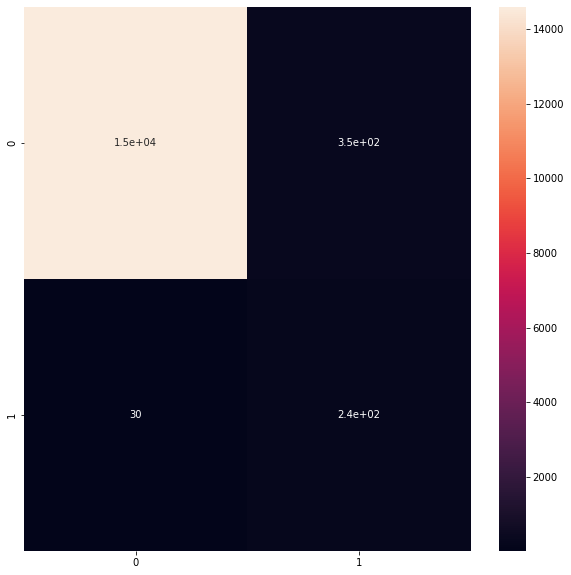

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14925
           1       0.48      0.91      0.63       275

    accuracy                           0.98     15200
   macro avg       0.74      0.95      0.81     15200
weighted avg       0.99      0.98      0.98     15200



new total cost : 3163500 | economy : 502500


In [11]:
svc = SVC(random_state = 16, gamma = 'scale', kernel = 'rbf')
svc.fit(x_resampled, y_resampled)
prev = svc.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, prev).ravel()
sum, economy = total_costs(tn, fp, fn, tp)
report = classification_report(y_test, prev)
matrix = confusion_matrix(y_test, prev)

plt.figure(figsize = (10,10))
sns.heatmap(matrix_6, annot = True)
plt.show()
print(report)
print('\n')
print(f'new total cost : {sum} | economy : {economy}')

## XGBoost 

using bayesian optimisation to find the parameters that fit better.

In [16]:
!pip install xgboost &> /dev/null
!pip install scikit-optimize &> /dev/null

from skopt import gp_minimize

from xgboost import XGBClassifier

def train_xgb(params):
  learning_rate = params[0]
  colsample_bytree = params[1]
  subsample = params[2]
  min_child_weight = params[3]
  
  model = XGBClassifier(n_estimators = 100, learning_rate = learning_rate, colsample_bytree = colsample_bytree,
                       subsample = subsample, min_child_weight= min_child_weight, random_state = 16)
  model.fit(x_resampled, y_resampled)
  prev = model.predict(x_test)
  report = classification_report(y_test, prev)
  tn, fp, fn, tp = confusion_matrix(y_test, prev).ravel()
  sum, economy = total_costs(tn, fp, fn, tp)

  return -economy


params = [(1e-3, 1e-1),
          (1e-1, 1.0),
          (0.5, 1.0),
          (5*1e2, 1e5)]

gp_minimize(train_xgb, params, verbose = 1, n_calls = 30, n_random_starts = 10, random_state = 16)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.3228
Function value obtained: 2334000.0000
Current minimum: 2334000.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.1615
Function value obtained: 2334000.0000
Current minimum: 2334000.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.6525
Function value obtained: 2334000.0000
Current minimum: 2334000.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 17.7364
Function value obtained: 2334000.0000
Current minimum: 2334000.0000
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.6583
Function value obtained: 2334000.0000


          fun: -462500
    func_vals: array([2334000, 2334000, 2334000, 2334000, 2334000, 2334000, 2334000,
       2334000, 2334000, 2334000,   54000, -462500, -325000, -377000,
       -462500, -462500, -462500, -462500, -462500, -462500, -462500,
       -462500, -462500, -462500, -462500, -462500, -462500, -462500,
       -462500, -462500])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=959027881), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=959027881), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_o